In [2173]:
%%html
<!-- run this to get markdown tables to align left -->
<style>table { display: inline-block }</style>

In [2174]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import sys
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn import impute
from sklearn import preprocessing
from scipy.stats import norm
np.random.seed(37)

sys.path.append(os.path.realpath('../src/data/'))
from sb_utils import save_file

### Import Data
Import the raw data from `data > raw` and write it out to the `data > interim directory`. We'll work from the interim folder.

In [2175]:
# the supplied CSV data file is the raw_data directory
aqi_df = pd.read_csv('../data/interim/aqi_yearly_1980_to_2021.csv')
aqi_df.sample(5)

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,...,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10,Latitude,Longitude
15185,Missouri,Clay,2002,364,162,162,30,10,0,0,...,108,53,0,21,153,4,186,0,39.331913,-94.580931
26564,Michigan,Clinton,2014,182,148,33,1,0,0,0,...,64,41,0,0,182,0,0,0,42.798339,-84.393795
16781,Georgia,Murray,2004,284,190,89,5,0,0,0,...,80,44,0,0,205,0,79,0,34.785219,-84.626423
2406,Arizona,Pinal,1985,365,100,43,100,122,0,0,...,200,119,0,0,0,365,0,0,33.293465,-111.285594
17637,Colorado,Larimer,2005,365,236,117,11,1,0,0,...,80,48,0,0,352,0,13,0,40.577470,-105.078920


In [2176]:
# the supplied CSV data file is the raw_data directory
cdi_df = pd.read_csv('../data/interim/US_Chronic_Disease_Indicators_CDI.csv')
cdi_df.sample(4)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,StratificationCategory1,Stratification1,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
1655,2010,2010,MO,Missouri,NVSS,Chronic Obstructive Pulmonary Disease,Mortality with chronic obstructive pulmonary d...,"cases per 100,000",Crude Rate,261.3,261.3,Overall,Overall,POINT (-92.56630005299968 38.635790776000476),29,COPD,COPD1_2,CRDRATE,OVERALL,OVR
1686,2018,2018,MT,Montana,NVSS,Chronic Obstructive Pulmonary Disease,Mortality with chronic obstructive pulmonary d...,"cases per 100,000",Crude Rate,143.0,143.0,Overall,Overall,POINT (-109.42442064499971 47.06652897200047),30,COPD,COPD1_1,CRDRATE,OVERALL,OVR
3760,2013,2013,TN,Tennessee,BRFSS,Chronic Obstructive Pulmonary Disease,Prevalence of chronic obstructive pulmonary di...,%,Crude Prevalence,9.5,9.5,Overall,Overall,POINT (-85.77449091399967 35.68094058000048),47,COPD,COPD2_0,CRDPREV,OVERALL,OVR
2807,2013,2013,IN,Indiana,BRFSS,Chronic Obstructive Pulmonary Disease,Prevalence of chronic obstructive pulmonary di...,%,Crude Prevalence,12.3,12.3,Overall,Overall,POINT (-86.14996019399968 39.766910452000445),18,COPD,COPD2_0_1,CRDPREV,OVERALL,OVR


The information about each measure is below. Note that all measures are per state.

| Topic         | Question      | Derivation |
| :------------- | :------------- | :---------- |
|  __Chronic Obstructive Pulmonary Disease__ | Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years  |  cases per 100,000 |
|   | Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years  |  cases per 100,000 |
|   | Prevalence of chronic obstructive pulmonary disease among adults >= 18  |  % of population |
|   | Prevalence of chronic obstructive pulmonary disease among adults >= 45 years  |  % of population |
|   | Prevalence of current smoking among adults >= 18 with diagnosed chronic obstructive pulmonary disease  |  % of population |
|   | Prevalence of current smoking among adults >= 45 years with diagnosed chronic obstructive pulmonary disease  |  % of population |
|  __Cancer__ | Cancer of the lung and bronchus, incidence  |  cases per 100,000 |
|   | Cancer of the lung and bronchus, mortality |  cases per 100,000 |
|  __Asthma__ | Current asthma prevalence among adults aged >= 18 years | % of population |


In [2177]:
cdi_df[cdi_df.DataValueAlt.isnull()]

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,StratificationCategory1,Stratification1,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
283,2019,2019,NJ,New Jersey,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,%,Crude Prevalence,NaN,NaN,Overall,Overall,POINT (-74.27369128799967 40.13057004800049),34,AST,AST1_1,CRDPREV,OVERALL,OVR
950,2012,2016,NV,Nevada,Statewide central cancer registries,Cancer,"Cancer of the lung and bronchus, incidence","per 100,000",Average Annual Crude Rate,NaN,NaN,Overall,Overall,POINT (-117.07184056399967 39.493240390000494),32,CAN,CAN8_1,AVGANNCRDRATE,OVERALL,OVR
970,2011,2015,NV,Nevada,Statewide central cancer registries,Cancer,"Cancer of the lung and bronchus, incidence","per 100,000",Average Annual Crude Rate,NaN,NaN,Overall,Overall,POINT (-117.07184056399967 39.493240390000494),32,CAN,CAN8_1,AVGANNCRDRATE,OVERALL,OVR
971,2010,2014,NV,Nevada,Statewide central cancer registries,Cancer,"Cancer of the lung and bronchus, incidence","per 100,000",Average Annual Crude Rate,NaN,NaN,Overall,Overall,POINT (-117.07184056399967 39.493240390000494),32,CAN,CAN8_1,AVGANNCRDRATE,OVERALL,OVR
981,2014,2018,NV,Nevada,Statewide central cancer registries,Cancer,"Cancer of the lung and bronchus, incidence","per 100,000",Average Annual Crude Rate,NaN,NaN,Overall,Overall,POINT (-117.07184056399967 39.493240390000494),32,CAN,CAN8_1,AVGANNCRDRATE,OVERALL,OVR
982,2009,2013,NV,Nevada,Statewide central cancer registries,Cancer,"Cancer of the lung and bronchus, incidence","per 100,000",Average Annual Crude Rate,NaN,NaN,Overall,Overall,POINT (-117.07184056399967 39.493240390000494),32,CAN,CAN8_1,AVGANNCRDRATE,OVERALL,OVR
989,2013,2017,NV,Nevada,Statewide central cancer registries,Cancer,"Cancer of the lung and bronchus, incidence","per 100,000",Average Annual Crude Rate,NaN,NaN,Overall,Overall,POINT (-117.07184056399967 39.493240390000494),32,CAN,CAN8_1,AVGANNCRDRATE,OVERALL,OVR
990,2008,2012,NV,Nevada,Statewide central cancer registries,Cancer,"Cancer of the lung and bronchus, incidence","per 100,000",Average Annual Crude Rate,NaN,NaN,Overall,Overall,POINT (-117.07184056399967 39.493240390000494),32,CAN,CAN8_1,AVGANNCRDRATE,OVERALL,OVR
3366,2019,2019,NJ,New Jersey,BRFSS,Chronic Obstructive Pulmonary Disease,Prevalence of chronic obstructive pulmonary di...,%,Crude Prevalence,NaN,NaN,Overall,Overall,POINT (-74.27369128799967 40.13057004800049),34,COPD,COPD2_0_1,CRDPREV,OVERALL,OVR
3372,2019,2019,NJ,New Jersey,BRFSS,Chronic Obstructive Pulmonary Disease,Prevalence of current smoking among adults >= ...,%,Crude Prevalence,NaN,NaN,Overall,Overall,POINT (-74.27369128799967 40.13057004800049),34,COPD,COPD3_0_1,CRDPREV,OVERALL,OVR


Lets remove the rows with empty values

In [2178]:
cdi_df = cdi_df[~ cdi_df.DataValueAlt.isnull()]
assert len(cdi_df[cdi_df.DataValueAlt.isnull()]) == 0

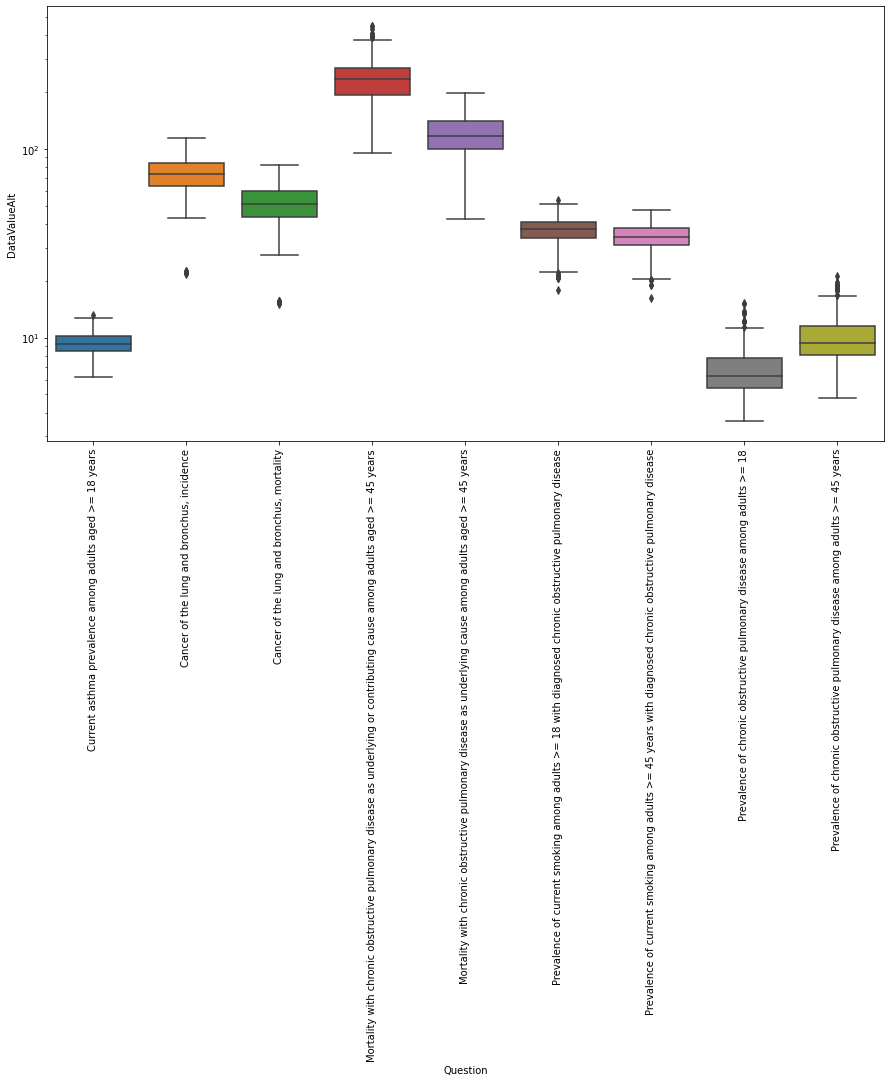

In [2179]:
# the overall mean, median, IQR for each Question in CDI
cols = ['LocationDesc','Question', 'DataValueAlt']

plt.subplots(figsize=(15, 8))
sns.boxplot(x='Question', y="DataValueAlt", data=cdi_df[cols]).set_yscale('log')
plt.xticks(rotation='vertical');

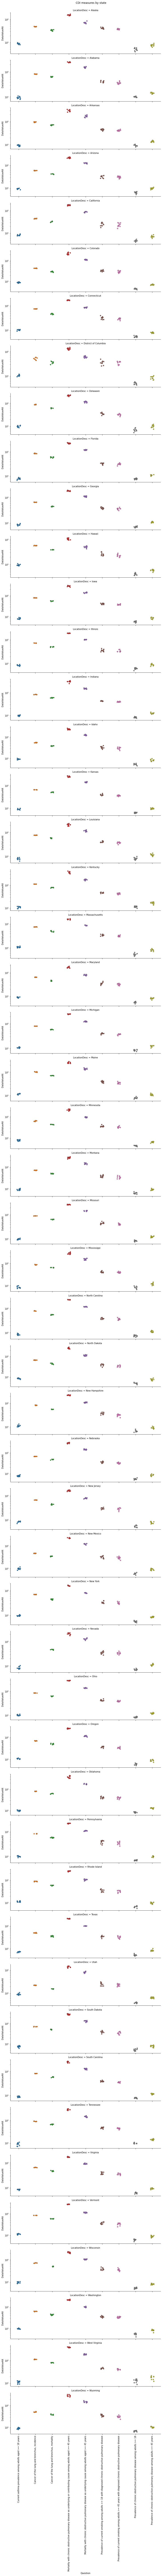

In [2180]:
# now by state - each marker in a given category (question) is the value for one year

g = sns.catplot(x="Question", y="DataValueAlt",
                hue="Question", col="LocationDesc",
                data=cdi_df[cols], kind="strip", col_wrap=1,
                height=3, aspect=4.5, sharex=True, sharey=False, linewidth=0.5)
g.fig.suptitle('CDI measures by state', y=1.0)
g.fig.subplots_adjust(top=0.99, hspace=0.4)
g.set(yscale="log")

plt.tight_layout()
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=90);

Build data profiles and tables
- Inferential statistics
Explore data relationships
- Data visualization
Feature Selection and Engineering
- If you have categorical features, you might need to one-hot encode them
- You may need to binarize your columns and bin your values.
- To handle missing data, think about how appropriate the methods of listwise deletion, data imputation, replacing missing values with constants or simply attempting to find the missing values are for your data.
- Think about whether you need to standardize, log-transform or normalize your data, as well as statistically valid ways to remove outliers.

Create hypotheses
    - Null and Alternative hypotheses

1. Are there variables that are particularly significant in terms of explaining the
answer to your project question?
2. Are there significant differences between subgroups in your data that may be
relevant to your project aim?
3. Are there strong correlations between pairs of independent variables or between
an independent and a dependent variable?
4. What are the most appropriate tests to use to analyze these relationships?


1. Form hypotheses/develop investigation themes to explore
2. Wrangle data
3. Assess the quality of data
4. Profile data
5. Explore each individual variable in the dataset
6. Assess the relationship between each variable and the target
7. Assess interactions between variables
8. Explore data across many dimensions
9. Feature Selection and Engineering

### Initial hypotheses/develop investigation themes to explore

The main question that I want to explore is whether the AQI rating (given as 90th percentile and median), or its categorization values ('Good Days', 'Moderate Days', 'Unhealthy for Sensitive Groups Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days') its component measures can predict outcomes in CDC data on asmtha, lung cancers, or COPD. 

Right now, the geolocation data in cdi_df is encoded as 'POINT (-147.72205903599973 64.84507995700051)'. In order to plot this, we'll need to break it into longitude and latitude data.

In [2181]:
# split the GeoLocation column into longitude and latitude cols
cdi_df[['Longitude','Latitude']] = cdi_df.GeoLocation.str.extract('^POINT+\s\((\-?\d+\.\d+)\s(\-?\d+\.\d+)\)$', expand=False)
cdi_df.loc[:,'Longitude'] = cdi_df.loc[:,'Longitude'].astype('float')
cdi_df.loc[:,'Latitude'] = cdi_df.loc[:,'Latitude'].astype('float')
# and drop GeoLocation column
cdi_df.drop(['GeoLocation'], axis=1, inplace=True)

cdi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4272 entries, 0 to 4283
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YearStart                  4272 non-null   int64  
 1   YearEnd                    4272 non-null   int64  
 2   LocationAbbr               4272 non-null   object 
 3   LocationDesc               4272 non-null   object 
 4   DataSource                 4272 non-null   object 
 5   Topic                      4272 non-null   object 
 6   Question                   4272 non-null   object 
 7   DataValueUnit              4272 non-null   object 
 8   DataValueType              4272 non-null   object 
 9   DataValue                  4272 non-null   float64
 10  DataValueAlt               4272 non-null   float64
 11  StratificationCategory1    4272 non-null   object 
 12  Stratification1            4272 non-null   object 
 13  LocationID                 4272 non-null   int64

To get an overview of the data in a geospacial sense, lets plot each of our topics by Question. We'll define a function to make plotting easier:

In [2182]:
def geo_plot_topic_by_question(data=None, topic=None, question=None, title=None):
    assert ~data.empty, "you must provide a dataframe"
    assert topic, "you must provide a topic"
    assert question, "you must provide a question"
    temp = data[(data['Topic'] == topic) & (data['Question'] == question)]
    temp = pd.melt(data,
                        id_vars=['LocationDesc','YearStart','Longitude','Latitude'], 
                        var_name='Measures', 
                        value_vars=['DataValueAlt'],
                        value_name='Target')
    # confine the plot to continental US
    temp.drop(temp[temp['Longitude'] < -125].index, inplace=True)

    # now plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(x=temp['Longitude'],y=temp['Latitude'], alpha=0.3, hue=temp['YearStart'], size=temp.Target).set(title=title)
    plt.legend(loc='lower right');

Plot asmtha prevalence

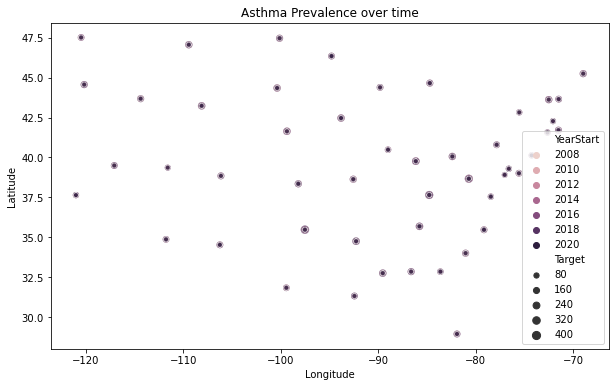

In [2183]:
geo_plot_topic_by_question(data=cdi_df,
                           topic='Asthma',
                           question='Current asthma prevalence among adults aged >= 18 years',
                           title = "Asthma Prevalence over time")

There are two questions associated with the cancer topic

In [2184]:
cdi_df[cdi_df['Topic'] == 'Cancer'].Question.unique()

array(['Cancer of the lung and bronchus, incidence',
       'Cancer of the lung and bronchus, mortality'], dtype=object)

Plot lung cancer incidence

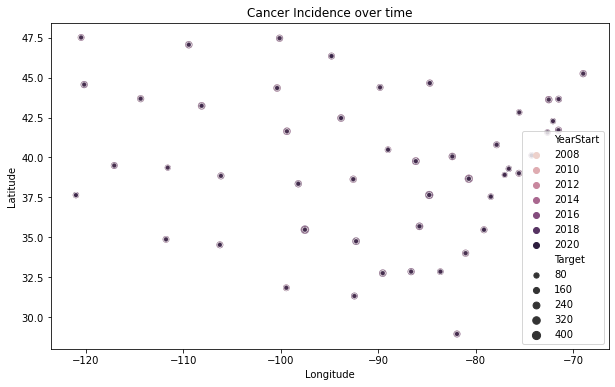

In [2185]:
geo_plot_topic_by_question(data=cdi_df,
                           topic='Cancer',
                           question='Cancer of the lung and bronchus, incidence',
                           title = "Cancer Incidence over time")

Plot Cancer mortality

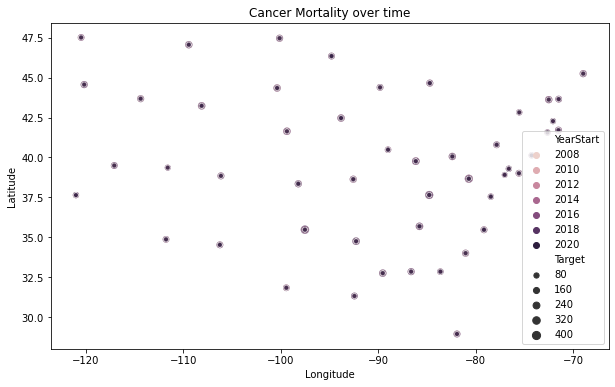

In [2186]:
geo_plot_topic_by_question(data=cdi_df,
                           topic='Cancer',
                           question='Cancer of the lung and bronchus, mortality',
                           title = "Cancer Mortality over time")

If nothing else, these give us a sense of the geographic locations of the measures. But its difficult to evaluate how these values change over time. For that, lets plot each topic/question as a bar graph.

In [2187]:
def bar_plot_topic_by_question(data=None, topic=None, question=None, title=None):
    assert ~data.empty, "you must provide a dataframe"
    assert topic, "you must provide a topic"
    assert question, "you must provide a question"
    temp = data[(data['Topic'] == topic) & (data['Question'] == question)]
    temp = temp.melt(id_vars=['YearStart','YearEnd','LocationAbbr'], 
                      value_vars=['DataValueAlt']).sort_values(by=['YearStart','LocationAbbr'])
    t = title or question
    locations = temp.LocationAbbr.unique()
    # plot
    try:
        g = sns.catplot(x="YearStart", y="value",
                        hue="YearStart", col="LocationAbbr",
                        data=temp, kind="bar", col_wrap=2,
                        height=2, aspect=2.7,sharex=False, sharey=False)
        g.fig.suptitle(t, y=1.0)
        g.fig.subplots_adjust(top=0.99, hspace=0.4)
        
        for i,ax in enumerate(g.axes.flat):
            # set value label on each bar
            for container in ax.containers:
                ax.bar_label(container)
            # set location on each subplot
            ax.set_title('State={}'.format(locations[i]))
 
    except KeyError as err:
        print()


Plot for Asthma

In [2188]:
cdi_df[cdi_df.Topic == 'Asthma'].Question.unique()

array(['Current asthma prevalence among adults aged >= 18 years'],
      dtype=object)

In [2189]:
# bar_plot_topic_by_question(cdi_df,
#                            'Asthma',
#                            'Current asthma prevalence among adults aged >= 18 years',
#                            'Asthma aged >= 18 years (% of population)'
#                           )

Plot for cancer incidence and mortality

In [2190]:
cdi_df[cdi_df.Topic == 'Cancer'].Question.unique()

array(['Cancer of the lung and bronchus, incidence',
       'Cancer of the lung and bronchus, mortality'], dtype=object)

In [2191]:
# bar_plot_topic_by_question(cdi_df,
#                            'Cancer',
#                            'Cancer of the lung and bronchus, incidence',
#                            'Cancer of the lung and bronchus, incidence (per 100K)',
#                           )

In [2192]:
# bar_plot_topic_by_question(cdi_df,
#                            'Cancer',
#                            'Cancer of the lung and bronchus, mortality',
#                            'Cancer of the lung and bronchus, mortality (per 100K)'
#                           )

Plot Chronic Obstructive Pulmonary Disease (COPD) questions

In [2193]:
cdi_df[cdi_df.Topic == 'Chronic Obstructive Pulmonary Disease'].Question.unique()

array(['Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years',
       'Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years',
       'Prevalence of current smoking among adults >= 18 with diagnosed chronic obstructive pulmonary disease',
       'Prevalence of current smoking among adults >= 45 years with diagnosed chronic obstructive pulmonary disease',
       'Prevalence of chronic obstructive pulmonary disease among adults >= 18',
       'Prevalence of chronic obstructive pulmonary disease among adults >= 45 years'],
      dtype=object)

In [2194]:
# bar_plot_topic_by_question(cdi_df,
#                            'Chronic Obstructive Pulmonary Disease',
#                            'Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years',
#                            'COPD mortality aged >= 45 years (per 100K)'
#                           )

In [2195]:
# bar_plot_topic_by_question(cdi_df,
#                            'Chronic Obstructive Pulmonary Disease',
#                            'Prevalence of chronic obstructive pulmonary disease among adults >= 45 years',
#                            'COPD prevalence aged >= 45 years (% of population)'
#                           )

Lets normalize the day measures by the number of day in which measures were taken ('Days AQI')

In [2196]:
# Good Days, Moderate Days, Unhealthy for Sensitive Groups Days, Unhealthy Days, Very Unhealthy Days, Hazardous Days
aqi_df.iloc[:,4:10] = aqi_df.iloc[:,4:10].apply(lambda x: x/aqi_df.iloc[:,3], axis=0)
# Days CO, Days NO2, Days Ozone, Days SO2, Days PM2.5, Days PM10
aqi_df.iloc[:,13:19] = aqi_df.iloc[:,13:19].apply(lambda x: x/aqi_df.iloc[:,3], axis=0)
aqi_df.sample(10)


,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,...,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10,Latitude,Longitude
30919,Tennessee,Williamson,2018,245,0.865306,0.130612,0.004082,0.000000,0.000000,0.000000,...,58,39,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,35.949765,-87.138246
1322,Pennsylvania,York,1982,347,0.501441,0.351585,0.129683,0.017291,0.000000,0.000000,...,108,50,0.008646,0.374640,0.340058,0.276657,0.000000,0.000000,39.875100,-76.912256
15233,New Hampshire,Merrimack,2002,365,0.621918,0.284932,0.079452,0.013699,0.000000,0.000000,...,99,40,0.000000,0.000000,0.336986,0.545205,0.115068,0.002740,43.218500,-71.514500
30051,West Virginia,Mason,2017,365,0.994521,0.005479,0.000000,0.000000,0.000000,0.000000,...,21,3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,38.956490,-82.088660
11915,Pennsylvania,Dauphin,1998,365,0.663014,0.191781,0.087671,0.054795,0.002740,0.000000,...,122,42,0.005479,0.452055,0.468493,0.071233,0.000000,0.002740,40.272222,-76.681389
23864,North Carolina,Person,2011,214,0.658879,0.317757,0.023364,0.000000,0.000000,0.000000,...,77,46,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,36.490020,-79.058272
8783,South Carolina,Darlington,1994,248,0.745968,0.177419,0.064516,0.012097,0.000000,0.000000,...,80,39,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,34.285696,-79.744859
16017,Maine,Cumberland,2003,365,0.876712,0.101370,0.021918,0.000000,0.000000,0.000000,...,52,37,0.000000,0.268493,0.643836,0.030137,0.038356,0.019178,43.832458,-70.063815
16647,California,Inyo,2004,366,0.459016,0.377049,0.095628,0.005464,0.008197,0.054645,...,119,57,0.000000,0.000000,0.756831,0.000000,0.024590,0.218579,37.155494,-118.293547
25346,Florida,Lake,2013,356,0.949438,0.047753,0.002809,0.000000,0.000000,0.000000,...,46,33,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,28.523889,-81.723333


Lets test the normalized data by overlaying it on the raw data. 

### Correlations

AQI data correlations

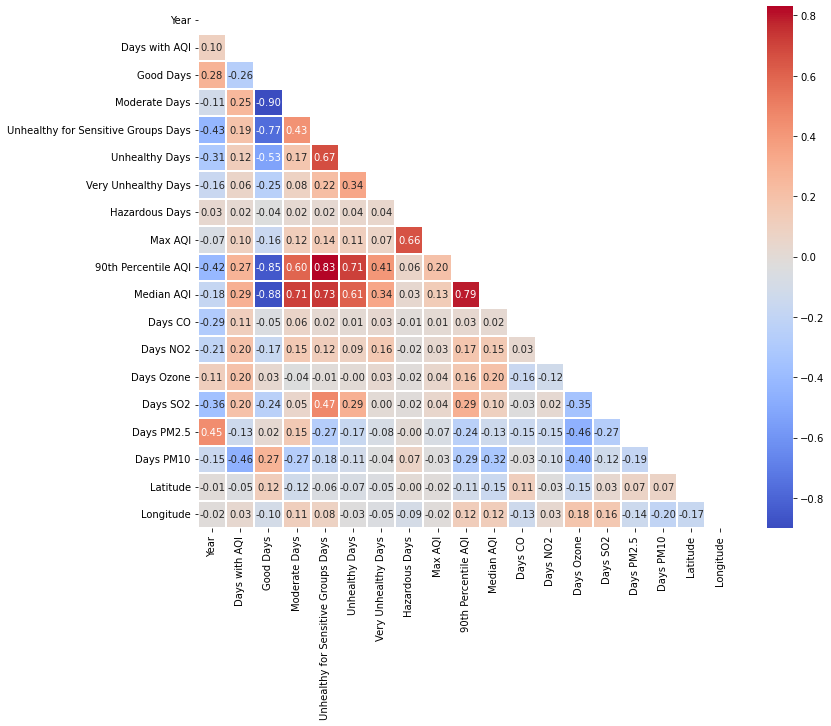

In [2197]:
corrmat = aqi_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# plot
f, ax = plt.subplots(figsize=(12, 9))
_ = sns.heatmap(round(corrmat,2), annot=True, mask=mask, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93);

CDI data correlations

Lets convert the Topic and Question categorical columns into one-hot encoded columns for correlation.

In [2198]:
cdi_df.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'DataValueUnit', 'DataValueType', 'DataValue',
       'DataValueAlt', 'StratificationCategory1', 'Stratification1',
       'LocationID', 'TopicID', 'QuestionID', 'DataValueTypeID',
       'StratificationCategoryID1', 'StratificationID1', 'Longitude',
       'Latitude'],
      dtype='object')

In [2199]:
cdi_df.shape

(4272, 21)

In [2200]:
cdi_df['Topic'].unique()

array(['Asthma', 'Cancer', 'Chronic Obstructive Pulmonary Disease'],
      dtype=object)

In [2201]:
# creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')
# perform one-hot encoding on 'Topic' column 
encoder_df = pd.DataFrame(encoder.fit_transform(cdi_df[['Topic']]).toarray())
# rename
encoder_df.columns = encoder.categories_[0]
# merge one-hot encoded columns back with original DataFrame
## MUST reset index before concat!
cdi_df.reset_index(drop=True, inplace=True)
encoder_df.reset_index(drop=True, inplace=True)
cdi_df = pd.concat([cdi_df, encoder_df], axis=1)
cdi_df.shape

(4272, 24)

In [2202]:
# do the same for 'Question' column
encoder_df = pd.DataFrame(encoder.fit_transform(cdi_df[['Question']]).toarray())
encoder_df.columns = encoder.categories_[0]
## MUST reset index before concat!
cdi_df.reset_index(drop=True, inplace=True)
encoder_df.reset_index(drop=True, inplace=True)
cdi_df = pd.concat([cdi_df, encoder_df], axis=1)
cdi_df.shape

(4272, 33)

In [2203]:
# drop columns that have been encoded
cdi_df.drop(['LocationAbbr','DataSource','DataValueUnit','DataValueType','Topic','Question','DataValue','StratificationCategory1','Stratification1','TopicID','QuestionID','DataValueTypeID','StratificationCategoryID1','StratificationID1'], axis=1, inplace=True)
# also drop (not needed)
cdi_df.drop(['LocationID','Longitude','Latitude'], axis=1, inplace=True)
#view final df
cdi_df.sample(10)

,YearStart,YearEnd,LocationDesc,DataValueAlt,Asthma,Cancer,Chronic Obstructive Pulmonary Disease,"Cancer of the lung and bronchus, incidence","Cancer of the lung and bronchus, mortality",Current asthma prevalence among adults aged >= 18 years,Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years,Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years,Prevalence of chronic obstructive pulmonary disease among adults >= 18,Prevalence of chronic obstructive pulmonary disease among adults >= 45 years,Prevalence of current smoking among adults >= 18 with diagnosed chronic obstructive pulmonary disease,Prevalence of current smoking among adults >= 45 years with diagnosed chronic obstructive pulmonary disease
4235,2020,2020,Utah,20.6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1698,2018,2018,Mississippi,168.2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
175,2012,2012,Massachusetts,10.8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1861,2010,2010,Oklahoma,334.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3237,2012,2012,North Carolina,6.8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
522,2014,2018,Alaska,30.9,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3360,2017,2017,New Jersey,6.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3202,2013,2013,Mississippi,12.3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1094,2008,2012,Utah,15.5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1834,2016,2016,Nevada,233.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Lets rename columns to make plotting less crowded.

In [2204]:
cdi_df.columns

Index(['YearStart', 'YearEnd', 'LocationDesc', 'DataValueAlt', 'Asthma',
       'Cancer', 'Chronic Obstructive Pulmonary Disease',
       'Cancer of the lung and bronchus, incidence',
       'Cancer of the lung and bronchus, mortality',
       'Current asthma prevalence among adults aged >= 18 years',
       'Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years',
       'Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years',
       'Prevalence of chronic obstructive pulmonary disease among adults >= 18',
       'Prevalence of chronic obstructive pulmonary disease among adults >= 45 years',
       'Prevalence of current smoking among adults >= 18 with diagnosed chronic obstructive pulmonary disease',
       'Prevalence of current smoking among adults >= 45 years with diagnosed chronic obstructive pulmonary disease'],
      dtype='object')

In [2205]:
cdi_df = cdi_df.rename({
    'Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years': 'COPD mortality age >= 45', 
    'Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years':'COPD contributing mortality age >= 45',
    'Prevalence of chronic obstructive pulmonary disease among adults >= 18':'COPD prevalence age >= 18',
    'Prevalence of chronic obstructive pulmonary disease among adults >= 45 years':'COPD prevalence age >= 45',
    'Prevalence of current smoking among adults >= 18 with diagnosed chronic obstructive pulmonary disease':'smoking and COPD prevalence age >= 18',
    'Prevalence of current smoking among adults >= 45 years with diagnosed chronic obstructive pulmonary disease':'smoking and COPD prevalence age >= 45',
    'Current asthma prevalence among adults aged >= 18 years':'Asthma prevalence age >= 18'
    }, axis='columns')
cdi_df.columns

Index(['YearStart', 'YearEnd', 'LocationDesc', 'DataValueAlt', 'Asthma',
       'Cancer', 'Chronic Obstructive Pulmonary Disease',
       'Cancer of the lung and bronchus, incidence',
       'Cancer of the lung and bronchus, mortality',
       'Asthma prevalence age >= 18', 'COPD mortality age >= 45',
       'COPD contributing mortality age >= 45', 'COPD prevalence age >= 18',
       'COPD prevalence age >= 45', 'smoking and COPD prevalence age >= 18',
       'smoking and COPD prevalence age >= 45'],
      dtype='object')

With columns encoded, we need to take the DataValueAlt value and copy it into the 'Question' column for which the value is intended.

In [2206]:
one_hot_cols = cdi_df.iloc[:,7:].columns.to_list()

def insert_value(row):
    for col in one_hot_cols:
        if row[col] == 1.0:
            row[col] = row['DataValueAlt']
            return row


cdi_df = cdi_df.apply(lambda row : insert_value(row), axis=1) 

# we don't need the DataValueAlt column anymore
cdi_df.drop(['DataValueAlt'], axis=1, inplace=True)

cdi_df.sample(10)

,YearStart,YearEnd,LocationDesc,Asthma,Cancer,Chronic Obstructive Pulmonary Disease,"Cancer of the lung and bronchus, incidence","Cancer of the lung and bronchus, mortality",Asthma prevalence age >= 18,COPD mortality age >= 45,COPD contributing mortality age >= 45,COPD prevalence age >= 18,COPD prevalence age >= 45,smoking and COPD prevalence age >= 18,smoking and COPD prevalence age >= 45
3371,2017,2017,New Jersey,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.4,0.0,0.0
2114,2016,2016,Wyoming,0.0,0.0,1.0,0.0,0.0,0.0,0.0,280.9,0.0,0.0,0.0,0.0
3075,2018,2018,Minnesota,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.7,0.0
2634,2013,2013,Hawaii,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.7,0.0,0.0,0.0
2441,2015,2015,Colorado,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.2,0.0
2238,2015,2015,Alaska,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
1758,2016,2016,New Hampshire,0.0,0.0,1.0,0.0,0.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0
763,2014,2018,Louisiana,0.0,1.0,0.0,75.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
859,2010,2014,Mississippi,0.0,1.0,0.0,0.0,65.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2098,2010,2010,West Virginia,0.0,0.0,1.0,0.0,0.0,0.0,0.0,362.1,0.0,0.0,0.0,0.0


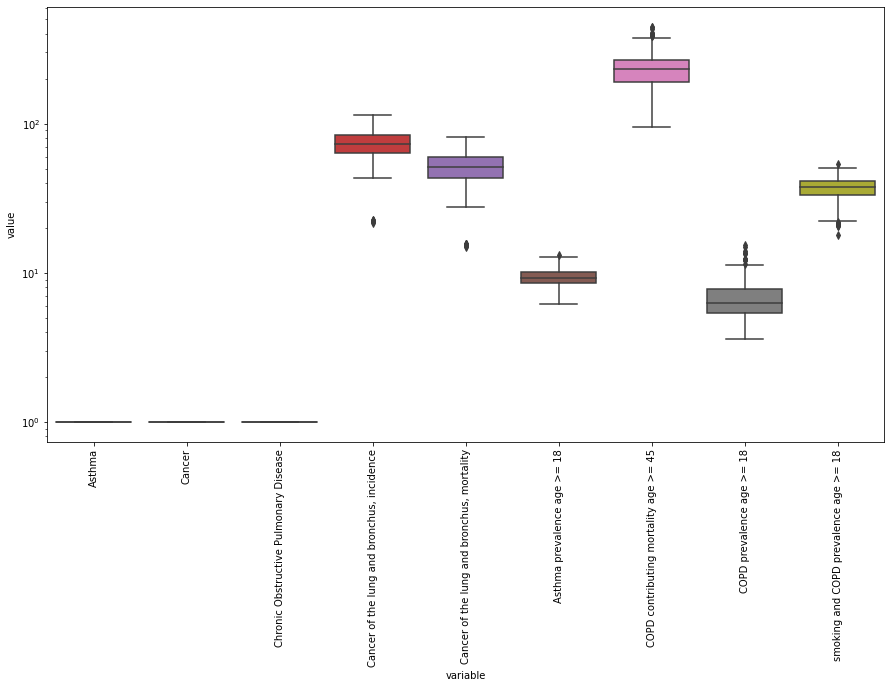

In [2207]:
# fill cancer columns with Nan where zero so that ignored in plots

cdi_df_temp = cdi_df.replace(0, np.nan)
# subset data for plotting
cdi_df_temp = cdi_df_temp[['Asthma', 'Cancer',
                'Chronic Obstructive Pulmonary Disease',
                'Cancer of the lung and bronchus, incidence',
                'Cancer of the lung and bronchus, mortality',
                'Asthma prevalence age >= 18',
                'COPD contributing mortality age >= 45',
                'COPD prevalence age >= 18',
                'smoking and COPD prevalence age >= 18']]

plt.subplots(figsize=(15, 8))
sns.boxplot(x="variable", y="value", data=pd.melt(cdi_df_temp)).set_yscale('log')
plt.xticks(rotation='vertical');

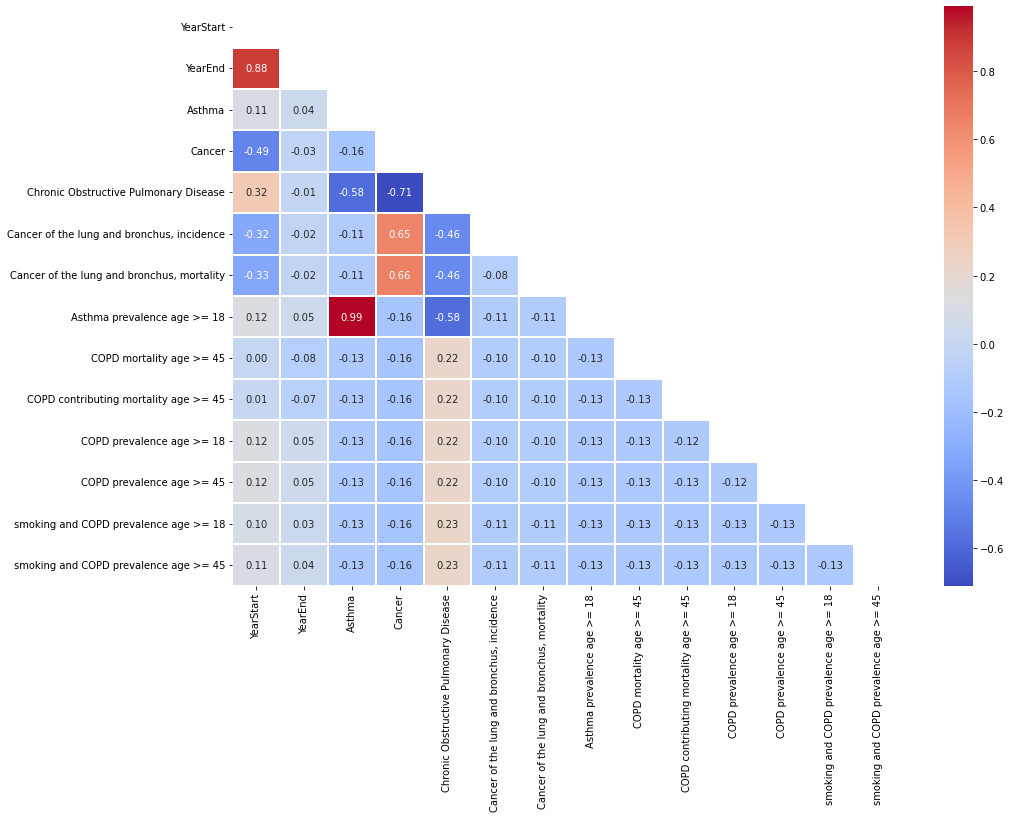

In [2208]:
corrmat = cdi_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# plot
f, ax = plt.subplots(figsize=(15, 10))
_ = sns.heatmap(round(corrmat,2), annot=True, mask=mask, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93);

Examine data before and after merge

First, lets fill the Nan values that were identified in the CDI data during the data cleaning and wrangling phase. We didn't want to impute misleading values at that time, but now our data is normalized and zero means no values.

In [2209]:
cdi_df.fillna(0, inplace=True)
# assert to ensure that there are no missing values
assert aqi_df[aqi_df.isna().any(axis=1)].shape[0] == 0
assert cdi_df[cdi_df.isna().any(axis=1)].shape[0] == 0

#### Check merge cols
We are merging on state and year so validate that these match across dataframes

##### State

In [2210]:
states_aqi = set(aqi_df.State)
states_cdi = set(cdi_df.LocationDesc)
# compare sets by difference (expect none)
diff = states_aqi.difference(states_cdi)
diff

{'District Of Columbia'}

Washington DC differs between the two frames:
The AQI dataset has 'District Of Columbia' while the CDI dataset has 'District of Columbia' (the difference is 'Of' vs 'of'). Lets correct this:

In [2211]:
aqi_df = aqi_df.replace('District Of Columbia','District of Columbia')

# check that there are no differences now
states_aqi = set(aqi_df.State)
states_cdi = set(cdi_df.LocationDesc)
# compare sets by difference (expect none)
diff = states_aqi.difference(states_cdi)
assert len(diff) == 0

##### Year

In [2212]:
year_aqi = set(aqi_df.Year)
year_cdi = set(cdi_df.YearStart)
trim_years = year_aqi.difference(year_cdi)
print(trim_years)

{1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007}


The AQI dataset contains forty years of data, but the CDI dataset only contains data from 2008-2020. Since we need to join them, I'll truncate the AQI years that precede the CDI years.

In [2213]:
aqi_df = aqi_df[~aqi_df['Year'].isin(list(trim_years))]
year_aqi = set(aqi_df.Year)
# make sure this worked
assert all(year >= 2008 for (year) in list(year_aqi))

We need to ensure that all (location, year) pairs align between dataframes 

In [2214]:
aqi_state_year = aqi_df[['State','Year']].drop_duplicates()
cdi_state_year = cdi_df[['LocationDesc','YearStart']].drop_duplicates()

# ensure that unique (location, year) pairs are same size
assert len(aqi_state_year) == len(cdi_state_year)

sorted_aqi_state_year = aqi_state_year.sort_values(by=['State','Year']).values.tolist()
sorted_cdi_state_year = cdi_state_year.sort_values(by=['LocationDesc','YearStart']).values.tolist()    
    
# ensure that unique (location, year) pairs are same values
def sublists_equal(a, b):
    return all(l for l in b if l in a)

print(sublists_equal(sorted_aqi_state_year, sorted_cdi_state_year))

True


Rename CDI index keys to match AQI for easier merge

In [2215]:
cdi_df = cdi_df.rename({
    'LocationDesc':'State',
    'YearStart':'Year'
    }, axis='columns')

In [2216]:
# don't think this is necessary now
cdi_df.drop(['YearEnd'], axis=1, inplace=True)

#### Group each dataset by State, Year

In [2217]:
aqi_by_state_year = aqi_df.groupby(['State', 'Year'])[['Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10']].mean()

cdi_by_state_year = cdi_df.groupby(['State', 'Year']).mean()

cdi_by_state_year

Asthma    Cancer  Chronic Obstructive Pulmonary Disease  \
State   Year                                                              
Alabama 2008  0.000000  1.000000                               0.000000   
        2009  0.000000  1.000000                               0.000000   
        2010  0.000000  0.500000                               0.500000   
        2011  0.111111  0.222222                               0.666667   
        2012  0.111111  0.222222                               0.666667   
...                ...       ...                                    ...   
Wyoming 2016  0.142857  0.000000                               0.857143   
        2017  0.142857  0.000000                               0.857143   
        2018  0.142857  0.000000                               0.857143   
        2019  0.142857  0.000000                               0.857143   
        2020  0.200000  0.000000                               0.800000   

              Cancer of the lung and bronchus, incidence  \
State   Year                                               
Alabama 2008                                   42.450000   
        2009                                   41.850000   
        2010                                   20.750000   
        2011                                    9.155556   
        2012                                    9.133333   
...                                                  ...   
Wyoming 2016                                    0.000000   
        2017                                    0.000000   
        2018                                    0.000000   
        2019                                    0.000000   
        2020                                    0.000000   

              Cancer of the lung and bronchus, mortality  \
State   Year                                               
Alabama 2008                                   33.150000   
        2009                                   33.150000   
        2010                                   16.350000   
        2011                                    7.133333   
        2012                                    7.044444   
...                                                  ...   
Wyoming 2016                                    0.000000   
        2017                                    0.000000   
        2018                                    0.000000   
        2019                                    0.000000   
        2020                                    0.000000   

              Asthma prevalence age >= 18  COPD mortality age >= 45  \
State   Year                                                          
Alabama 2008                     0.000000                  0.000000   
        2009                     0.000000                  0.000000   
        2010                     0.000000                 35.625000   
        2011                     0.888889                 16.044444   
        2012                     0.955556                 16.366667   
...                                   ...                       ...   
Wyoming 2016                     1.357143                 19.200000   
        2017                     1.300000                 21.385714   
        2018                     1.242857                 23.914286   
        2019                     1.357143                 22.100000   
        2020                     2.000000                  0.000000   

              COPD contributing mortality age >= 45  \
State   Year                                          
Alabama 2008                               0.000000   
        2009                               0.000000   
        2010                              61.225000   
        2011                              27.555556   
        2012                              27.244444   
...                                             ...   
Wyoming 2016                              40.128571   
        2017                              40.800000   
    

Let's look at the missing cancer data.

In [2218]:
cancer_missing = cdi_by_state_year[(cdi_by_state_year['Cancer of the lung and bronchus, incidence']) <= 0 |
                  (cdi_by_state_year['Cancer of the lung and bronchus, mortality'] <= 0)].reset_index()

cancer_missing.Year.value_counts()

2015    51
2016    51
2017    51
2018    51
2019    51
2020    51
2008     1
2009     1
2010     1
2011     1
2012     1
2013     1
2014     1
Name: Year, dtype: int64

From this it's clear that all states are missing study values from 2015-2020. Cancer studies are actually four years in term, so we'll distribute the values of the last study (ending in 2014 out to 2018).

In [2219]:
## Extend 2014 cancer trial out to 2018
# incidence rows
cdi_by_state_year['Cancer of the lung and bronchus, incidence'] = cdi_by_state_year['Cancer of the lung and bronchus, incidence'].replace(0,np.nan)
cdi_by_state_year['Cancer of the lung and bronchus, incidence'] = cdi_by_state_year['Cancer of the lung and bronchus, incidence'].fillna(method="ffill", limit=4)
# mortality
cdi_by_state_year['Cancer of the lung and bronchus, mortality'] = cdi_by_state_year['Cancer of the lung and bronchus, mortality'].replace(0,np.nan)
cdi_by_state_year['Cancer of the lung and bronchus, mortality'] = cdi_by_state_year['Cancer of the lung and bronchus, mortality'].fillna(method="ffill", limit=4)

# count again to see that fill worked
cancer_missing = cdi_by_state_year[(cdi_by_state_year['Cancer of the lung and bronchus, incidence']).isnull() |
                  (cdi_by_state_year['Cancer of the lung and bronchus, mortality'].isnull())].reset_index()


Great - that is what we are expecting. There is no imputable data for 2019 or 2020 for all states. The other missing values are simply states that have no reported data:

In [2220]:
cancer_missing[cancer_missing.Year.isin([2008,2009,2010,2011,2012,2013,2014])] 

,State,Year,Asthma,Cancer,Chronic Obstructive Pulmonary Disease,"Cancer of the lung and bronchus, incidence","Cancer of the lung and bronchus, mortality",Asthma prevalence age >= 18,COPD mortality age >= 45,COPD contributing mortality age >= 45,COPD prevalence age >= 18,COPD prevalence age >= 45,smoking and COPD prevalence age >= 18,smoking and COPD prevalence age >= 45
56,Nevada,2008,0.000,1.000000,0.000000,NaN,48.500000,0.0000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000
57,Nevada,2009,0.000,1.000000,0.000000,NaN,48.100000,0.0000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000
58,Nevada,2010,0.000,0.333333,0.666667,NaN,16.066667,0.0000,37.833333,59.3000,0.0000,0.0000,0.000,0.0000
59,Nevada,2011,0.125,0.125000,0.750000,NaN,6.025000,1.0125,14.625000,23.6625,0.9125,1.4500,4.875,4.1000
60,Nevada,2012,0.125,0.125000,0.750000,NaN,5.887500,0.9250,15.700000,24.8750,0.9375,1.6000,3.900,4.0625
61,Nevada,2013,0.125,0.125000,0.750000,NaN,5.800000,0.9500,16.475000,26.2250,0.8375,1.2250,5.275,5.1000
62,Nevada,2014,0.125,0.125000,0.750000,NaN,5.575000,1.0125,16.425000,25.9250,0.8625,1.3625,4.325,4.0000


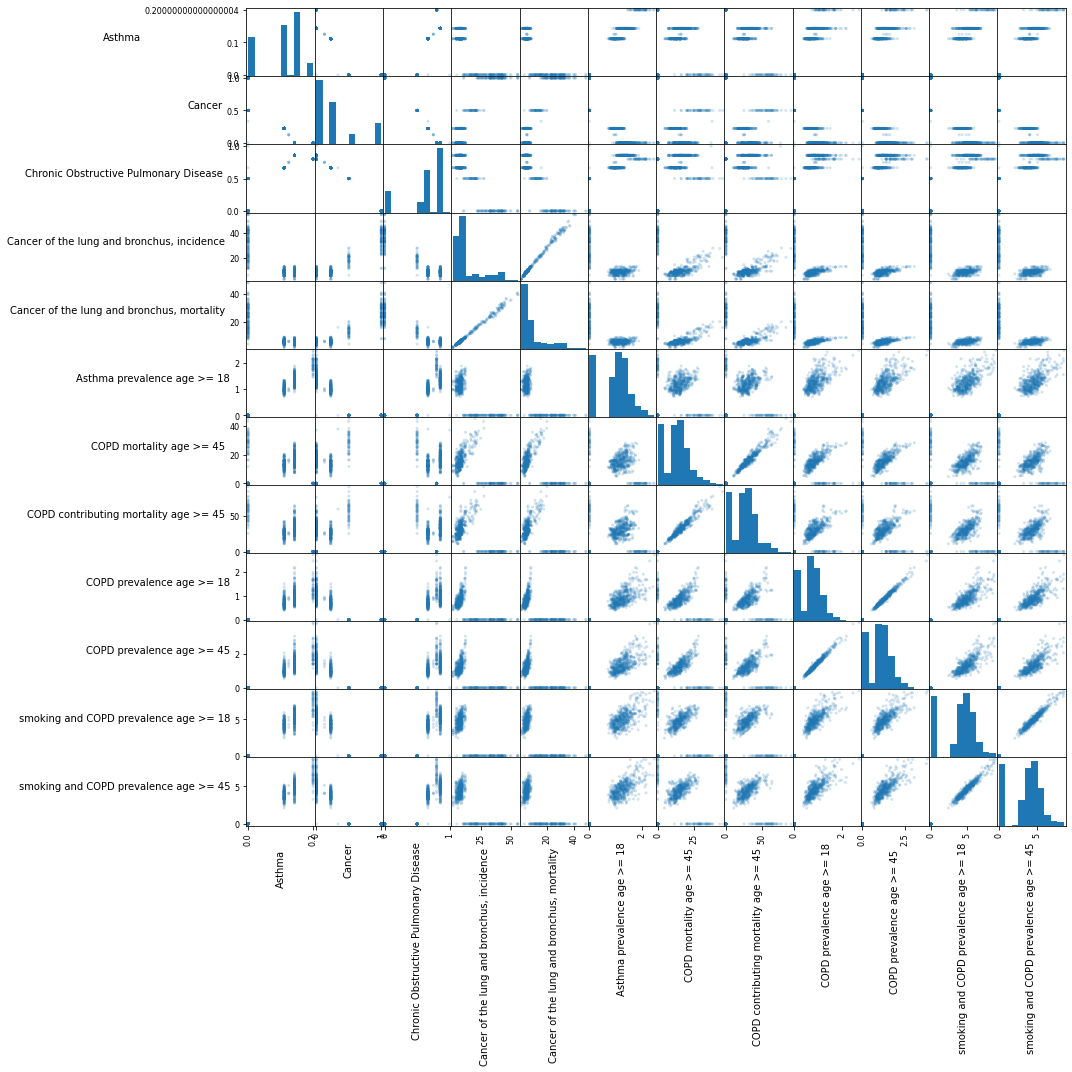

In [2221]:
axes = pd.plotting.scatter_matrix(cdi_by_state_year, alpha=0.2, figsize=(15,15))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

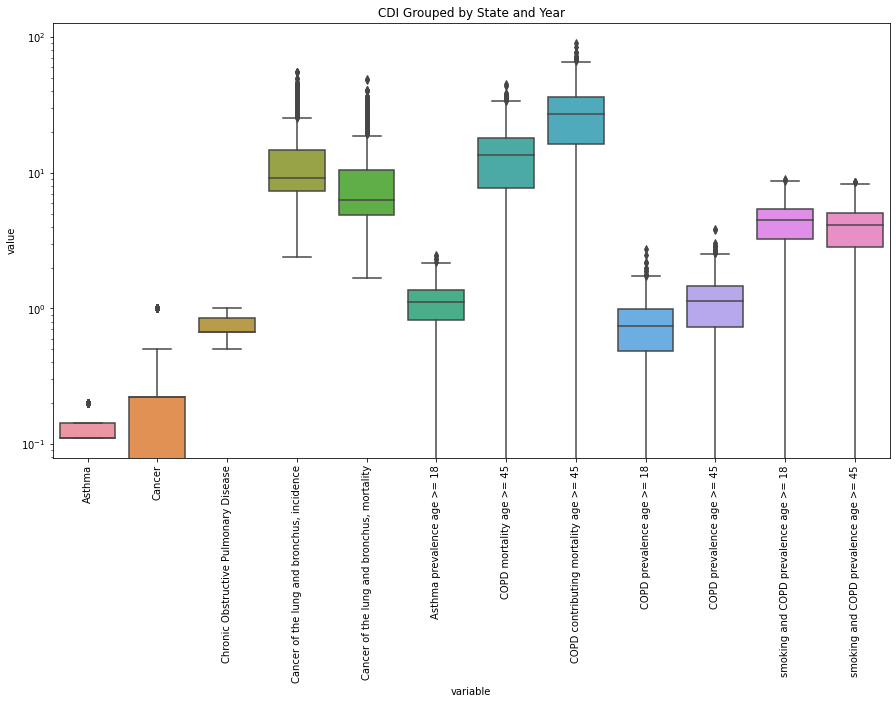

In [2222]:
plt.subplots(figsize=(15, 8))
g = sns.boxplot(x="variable", y="value", data=pd.melt(cdi_by_state_year))
g.set_title('CDI Grouped by State and Year')
g.set_yscale('log')
plt.xticks(rotation='vertical');

#### MERGE

In [2223]:
merged_df = aqi_by_state_year.merge(cdi_by_state_year, left_index=True, right_index=True, how='left')
merged_df.sample(10)


,,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,...,Chronic Obstructive Pulmonary Disease,"Cancer of the lung and bronchus, incidence","Cancer of the lung and bronchus, mortality",Asthma prevalence age >= 18,COPD mortality age >= 45,COPD contributing mortality age >= 45,COPD prevalence age >= 18,COPD prevalence age >= 45,smoking and COPD prevalence age >= 18,smoking and COPD prevalence age >= 45
State,Year,,,,,,,,,,,,,,,,,,,,,
West Virginia,2009,301.000000,0.656905,0.317262,0.024266,0.001567,0.000000,0.0,115.785714,67.142857,44.142857,...,0.000000,54.800000,40.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Nebraska,2017,246.000000,0.877734,0.120028,0.002238,0.000000,0.000000,0.0,93.777778,49.000000,28.555556,...,0.857143,7.344444,4.966667,1.171429,22.214286,45.100000,0.814286,1.285714,5.200000,4.957143
Alaska,2014,298.000000,0.816938,0.143529,0.018472,0.020277,0.000784,0.0,148.428571,66.142857,26.285714,...,0.666667,5.511111,3.433333,0.900000,7.733333,16.711111,0.488889,0.822222,4.311111,4.200000
Texas,2010,345.536585,0.755628,0.224967,0.017267,0.002139,0.000000,0.0,123.073171,63.365854,39.487805,...,0.500000,12.600000,9.175000,0.000000,25.025000,50.775000,0.000000,0.000000,0.000000,0.000000
Delaware,2009,295.000000,0.688769,0.302255,0.007150,0.001826,0.000000,0.0,118.666667,72.000000,44.000000,...,0.000000,43.050000,31.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Kentucky,2010,310.758621,0.673481,0.304969,0.021124,0.000425,0.000000,0.0,119.103448,71.241379,43.620690,...,0.500000,27.800000,19.975000,0.000000,38.425000,77.225000,0.000000,0.000000,0.000000,0.000000
West Virginia,2010,299.571429,0.635187,0.340377,0.022593,0.001842,0.000000,0.0,133.214286,73.357143,44.571429,...,0.500000,27.425000,20.150000,0.000000,43.175000,90.525000,0.000000,0.000000,0.000000,0.000000
Maryland,2012,313.200000,0.630937,0.315340,0.043805,0.009052,0.000866,0.0,180.533333,83.333333,45.266667,...,0.666667,7.166667,5.000000,1.000000,8.655556,17.733333,0.611111,0.877778,4.333333,3.766667
North Dakota,2014,364.555556,0.924136,0.070077,0.004873,0.000609,0.000304,0.0,124.111111,49.000000,35.000000,...,0.666667,7.377778,4.500000,0.966667,11.844444,26.566667,0.522222,0.844444,3.322222,3.422222


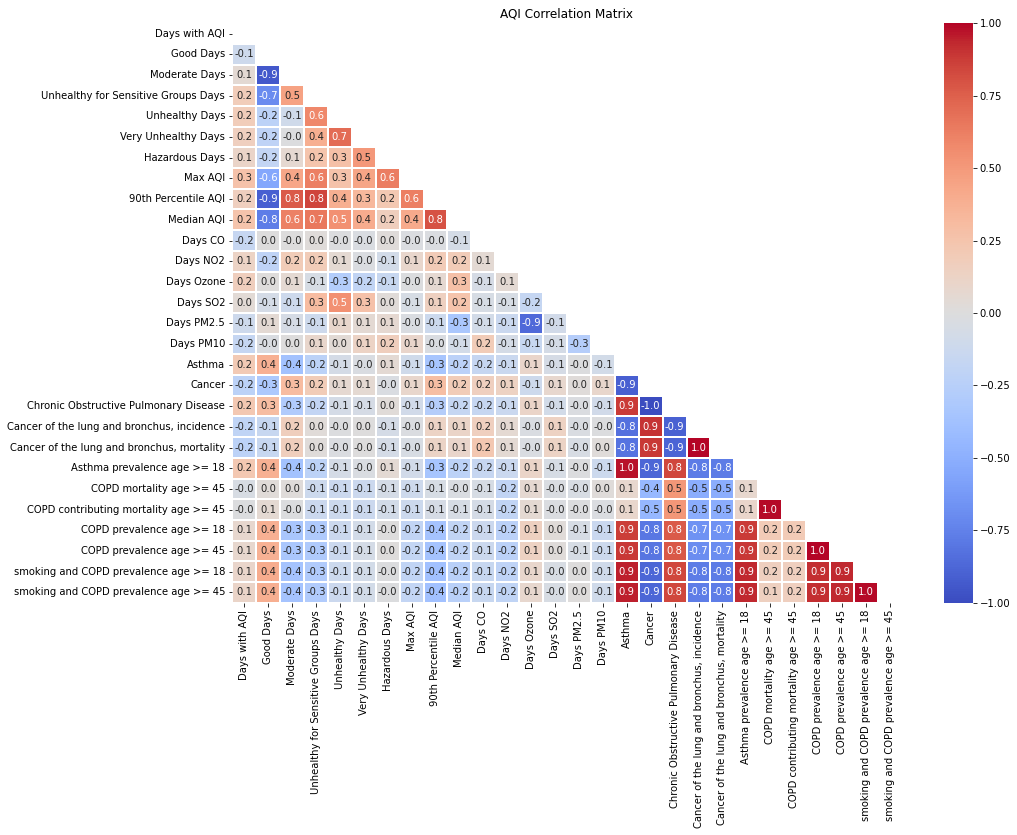

In [2224]:
corrmat = merged_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# plot
f, ax = plt.subplots(figsize=(15, 10))
_ = sns.heatmap(round(corrmat,2), annot=True, mask=mask, ax=ax, cmap="coolwarm",fmt='.1f', linewidths=.05).set_title("AQI Correlation Matrix")
f.subplots_adjust(top=0.93);

Interestingly, AQI 'Good Days' are positively correlated with Asthma prevalence and with COPD prevalence - but (weakly) negatively correlated with Cancer incidence and mortality. As we progress towards worse AQI measures, the COPD prevalences actually invert to negative correlations, getting smaller in magnitude as we approach 'Hazardous Days'. COPD mortality looks to be uncorrelated to AQI. Cancer incidence and mortality is positively correlated to 'Moderate Days', but again the effect diminishes as AQI gets worse. 

I'm not sure what causes these effects. They're counterintuitive to what I would expect. Maybe its an artifact of the relative sizes of the set of good vs the others. The number of good days is more than the number of moderate days as so on down to Hazardous days. There may be some lurking or confounding evidence here. But for now, I am accepting that data as it is.

Asthma prevalence is tighly correlated with COPD prevalence. But cancer incidence and mortality are strongly negatively correlated with both COPD and Asthma prevalences, as well as to (to a lesser but still significant way) COPD mortality.

The COPD correlation is also surprising. I would definitely expect a positive correlation between lung cancers and COPD. But it appears that Asthma and COPD are more likely to be co-morbidities. And both Asthma and COPD seem to be mutually exclusive to lung cancers.

Explore distributions

In [2139]:
def plot_cdf_pdf(x):
    y_pdf = norm.pdf(x)
    y_cdf = norm.cdf(x)
    fig, ax = plt.subplots(figsize=(15, 6))
    ax = [ax, ax.twinx()]
    _ = ax[0].plot(x, y_pdf, label='pdf', color='r')
    _ = ax[1].plot(x, y_cdf, label='cdf', color='b')
    _ = ax[0].tick_params(axis='y', labelcolor='r')
    _ = ax[1].tick_params(axis='y', labelcolor='b')
    _ = ax[0].set_ylabel('pdf', color='r')
    _ = ax[1].set_ylabel('cdf', color='b')
    _ = ax[0].set_title('PDF and CDF of standard normal')

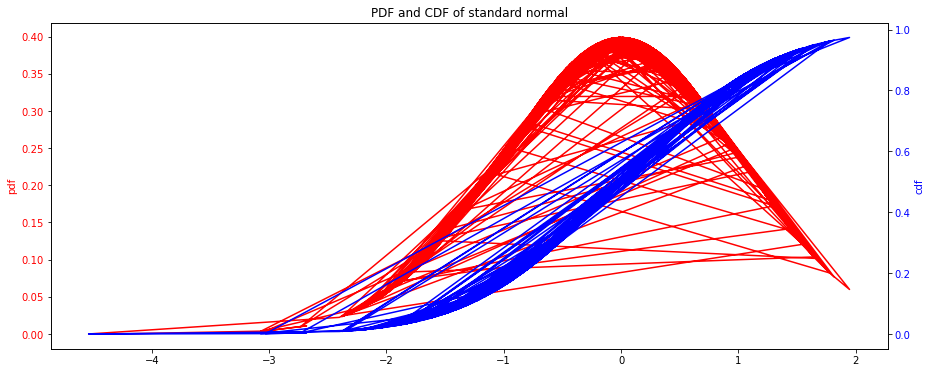

In [2172]:
plot_cdf_pdf(merged_df['Good Days'])

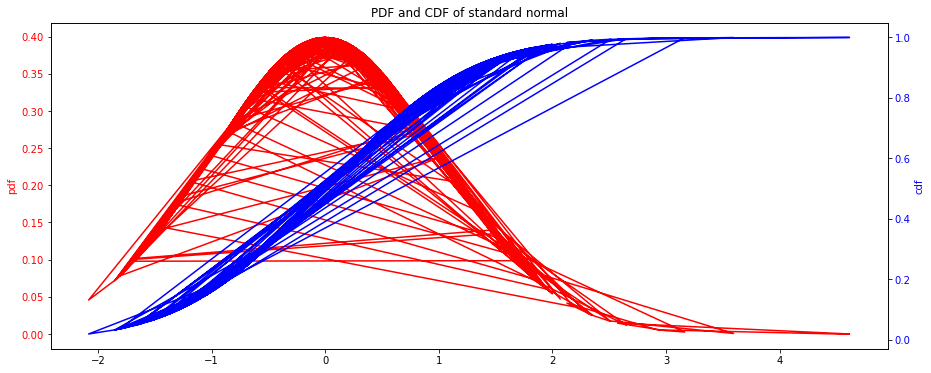

In [2143]:
plot_cdf_pdf(merged_df['Moderate Days'])

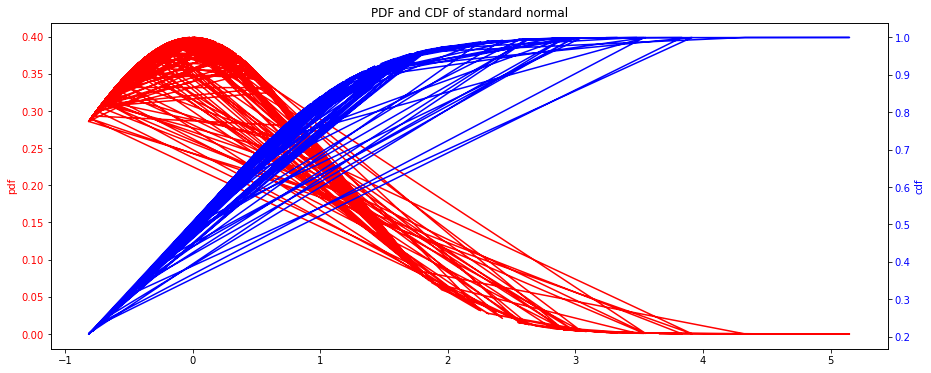

In [2144]:
plot_cdf_pdf(merged_df['Unhealthy for Sensitive Groups Days'])

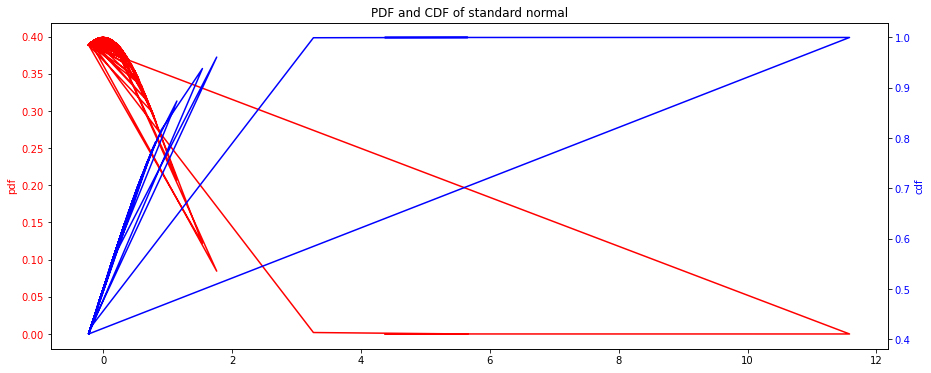

In [2169]:
plot_cdf_pdf(merged_df['Unhealthy Days'])

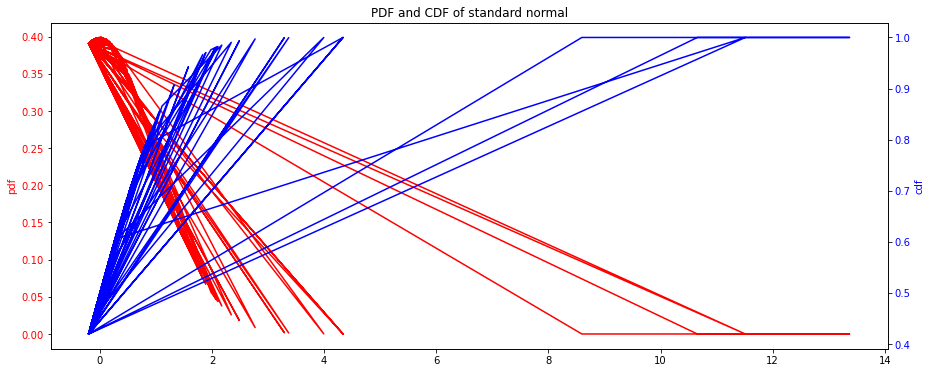

In [2170]:
plot_cdf_pdf(merged_df['Very Unhealthy Days'])

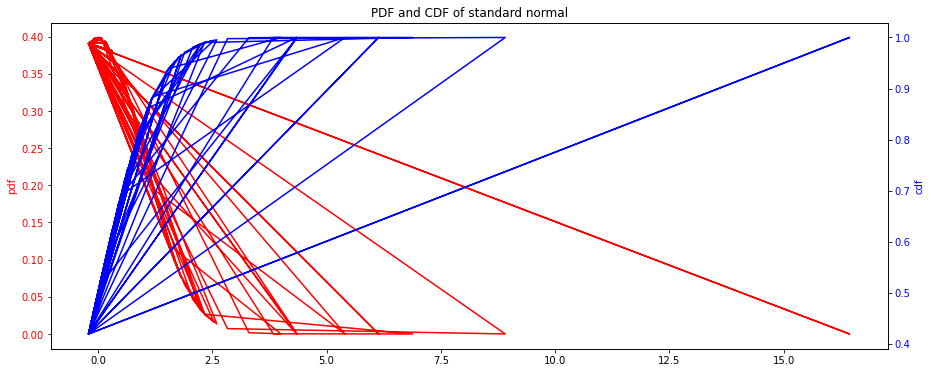

In [2171]:
plot_cdf_pdf(merged_df['Hazardous Days'])

It appears that 'COPD mortality age >= 45' and 'COPD contributing mortality age >= 45' contain the same correlation values. The same goes for 'COPD prevalence age >= 18' and 'COPD prevalence age >= 45' as well as 'smoking and COPD prevalence age >= 18' and 'smoking and COPD prevalence age >= 45'. To stay consistent with the 'Asthma prevalence age >= 18' column, I'll keep the >= 18 measures and drop the following columns:
- 'COPD mortality age >= 45'
- 'COPD prevalence age >= 45'
- 'smoking and COPD prevalence age >= 45'

In [313]:
merged_df_cols = merged_df.shape[1]
merged_df.drop(['COPD mortality age >= 45','COPD prevalence age >= 45','smoking and COPD prevalence age >= 45'], axis=1, inplace=True)
assert merged_df.shape[1] == merged_df_cols - 3

In [314]:
merged_df.sort_values(by=['State','Year'])

Days with AQI  Good Days  Moderate Days  \
State   Year                                            
Alabama 2008     286.200000   0.647487       0.337735   
        2009     288.133333   0.759017       0.237305   
        2010     294.733333   0.616788       0.367624   
        2011     262.866667   0.700772       0.282139   
        2012     271.285714   0.776745       0.210611   
...                     ...        ...            ...   
Wyoming 2016     328.529412   0.877084       0.122112   
        2017     331.529412   0.790841       0.202068   
        2018     331.055556   0.788808       0.206710   
        2019     344.222222   0.869550       0.126328   
        2020     344.055556   0.862433       0.126288   

              Unhealthy for Sensitive Groups Days  Unhealthy Days  \
State   Year                                                        
Alabama 2008                             0.013580        0.001198   
        2009                             0.003679        0.000000   
        2010                             0.014378        0.001210   
        2011                             0.015756        0.001332   
        2012                             0.011863        0.000781   
...                                           ...             ...   
Wyoming 2016                             0.000643        0.000161   
        2017                             0.005157        0.001450   
        2018                             0.004025        0.000457   
        2019                             0.003666        0.000457   
        2020                             0.008602        0.002277   

              Very Unhealthy Days  Hazardous Days     Max AQI  \
State   Year                                                    
Alabama 2008             0.000000        0.000000  119.733333   
        2009             0.000000        0.000000  104.266667   
        2010             0.000000        0.000000  117.533333   
        2011             0.000000        0.000000  116.000000   
        2012             0.000000        0.000000  111.714286   
...                           ...             ...         ...   
Wyoming 2016             0.000000        0.000000   97.000000   
        2017             0.000322        0.000161  169.411765   
        2018             0.000000        0.000000  107.777778   
        2019             0.000000        0.000000  101.500000   
        2020             0.000248        0.000152  196.666667   

              90th Percentile AQI  Median AQI  ...  Days PM10    Asthma  \
State   Year                                   ...                        
Alabama 2008            69.533333   44.133333  ...   0.025596  0.000000   
        2009            58.666667   39.333333  ...   0.026641  0.000000   
        2010            71.933333   45.933333  ...   0.031774  0.000000   
        2011            70.866667   42.466667  ...   0.018202  0.111111   
        2012            62.928571   40.214286  ...   0.012752  0.111111   
...                           ...         ...  ...        ...       ...   
Wyoming 2016            50.941176   37.000000  ...   0.178828  0.142857   
        2017            59.529412   38.470588  ...   0.175581  0.142857   
        2018            58.777778   39.555556  ...   0.164008  0.142857   
        2019            52.222222   38.833333  ...   0.157405  0.142857   
        2020            52.000000   35.555556  ...   0.209326  0.200000   

                Cancer  Chronic Obstructive Pulmonary Disease  \
State   Year                                                    
Alabama 2008  1.000000                               0.000000   
        2009  1.000000                               0.000000   
        2010  0.500000                               0.500000   
        2011  0.222222                               0.666667   
        2012  0.222222                               0.666667   
...                ...                                    ...   
Wyoming 2016  0.000000          

#### Standardize Data
Standardize features by removing the mean and scaling to unit variance. This allows us to treat the data as if it were normally distributed.

In [2055]:


num_pipeline = Pipeline([
    #('imputer', impute.SimpleImputer(strategy='median')),
    #('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', preprocessing.StandardScaler())
])
merged_df[merged_df.columns] = num_pipeline.fit_transform(merged_df)
merged_df.sort_values(by=['State','Year'])

Days with AQI  Good Days  Moderate Days  \
State   Year                                            
Alabama 2008      -0.986944  -1.466906       1.720842   
        2009      -0.927490  -0.326800       0.551916   
        2010      -0.724525  -1.780720       2.068721   
        2011      -1.704497  -0.922197       1.073748   
        2012      -1.445592  -0.145575       0.241227   
...                     ...        ...            ...   
Wyoming 2016       0.314780   0.880136      -0.788823   
        2017       0.407037  -0.001480       0.141795   
        2018       0.392465  -0.022259       0.195826   
        2019       0.797370   0.803116      -0.739755   
        2020       0.792244   0.730367      -0.740223   

              Unhealthy for Sensitive Groups Days  Unhealthy Days  \
State   Year                                                        
Alabama 2008                            -0.042992       -0.164624   
        2009                            -0.606457       -0.226271   
        2010                             0.002410       -0.164000   
        2011                             0.080874       -0.157717   
        2012                            -0.140674       -0.186103   
...                                           ...             ...   
Wyoming 2016                            -0.779223       -0.218001   
        2017                            -0.522321       -0.151638   
        2018                            -0.586757       -0.202776   
        2019                            -0.607200       -0.202776   
        2020                            -0.326251       -0.109114   

              Very Unhealthy Days  Hazardous Days   Max AQI  \
State   Year                                                  
Alabama 2008            -0.203091       -0.204273 -0.082339   
        2009            -0.203091       -0.204273 -0.450583   
        2010            -0.203091       -0.204273 -0.134718   
        2011            -0.203091       -0.204273 -0.171225   
        2012            -0.203091       -0.204273 -0.273264   
...                           ...             ...       ...   
Wyoming 2016            -0.203091       -0.204273 -0.623595   
        2017             0.036438        0.063754  1.100451   
        2018            -0.203091       -0.204273 -0.366988   
        2019            -0.203091       -0.204273 -0.516455   
        2020            -0.018781        0.048172  1.749361   

              90th Percentile AQI  Median AQI  ...  \
State   Year                                   ...   
Alabama 2008             0.875468    1.027625  ...   
        2009            -0.105942    0.342048  ...   
        2010             1.092221    1.284716  ...   
        2011             0.995886    0.789577  ...   
        2012             0.278966    0.467873  ...   
...                           ...         ...  ...   
Wyoming 2016            -0.803661    0.008782  ...   
        2017            -0.028025    0.218823  ...   
        2018            -0.095908    0.373788  ...   
        2019            -0.687965    0.270634  ...   
        2020            -0.708034   -0.197526  ...   

              Chronic Obstructive Pulmonary Disease  \
State   Year                                          
Alabama 2008                              -2.180759   
        2009                              -2.180759   
        2010                              -0.465701   
        2011                               0.105986   
        2012                               0.105986   
...                                             ...   
Wyoming 2016                               0.759341   
        2017                               0.759341   
        2018                               0.759341   
        2019                               0.759341   
        2020                               0.563334   

              Cancer of the lung and bronchus, incidence  \
State   Year                                               
Alabama 2008   

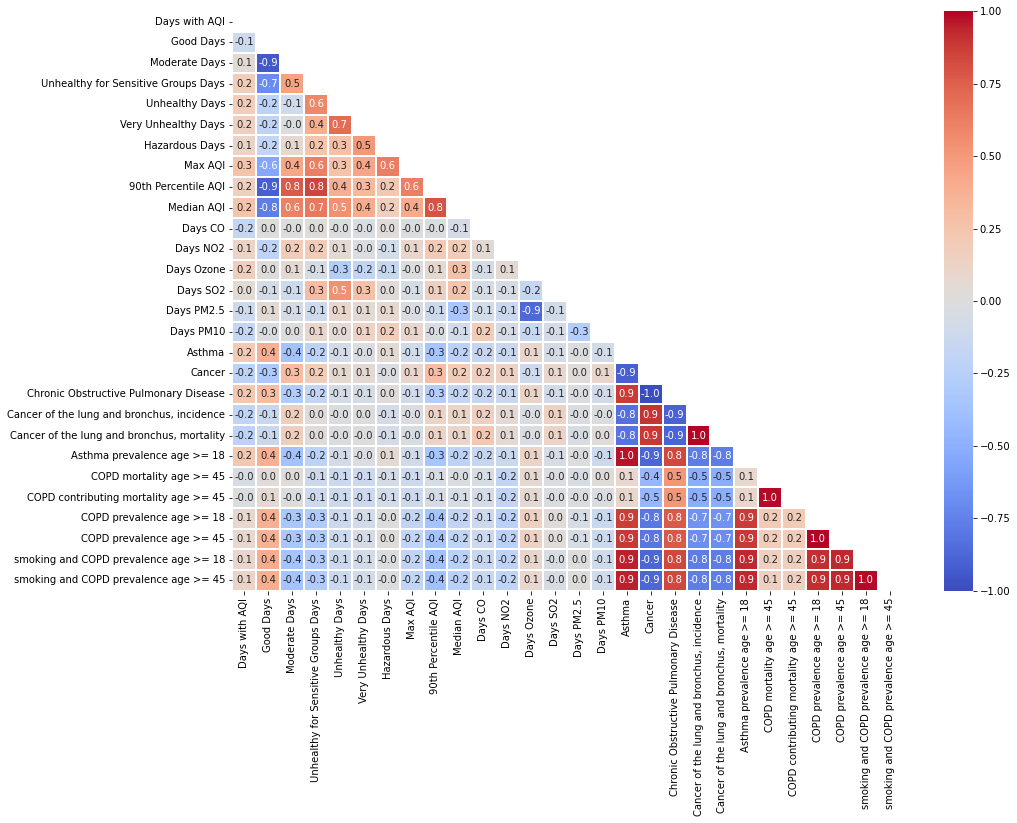

In [2056]:
corrmat = merged_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# plot
f, ax = plt.subplots(figsize=(15, 10))
_ = sns.heatmap(round(corrmat,2), annot=True, mask=mask, ax=ax, cmap="coolwarm",fmt='.1f', linewidths=.05)
f.subplots_adjust(top=0.93);

Lets look closer at the correlations using a scatter plot matrix

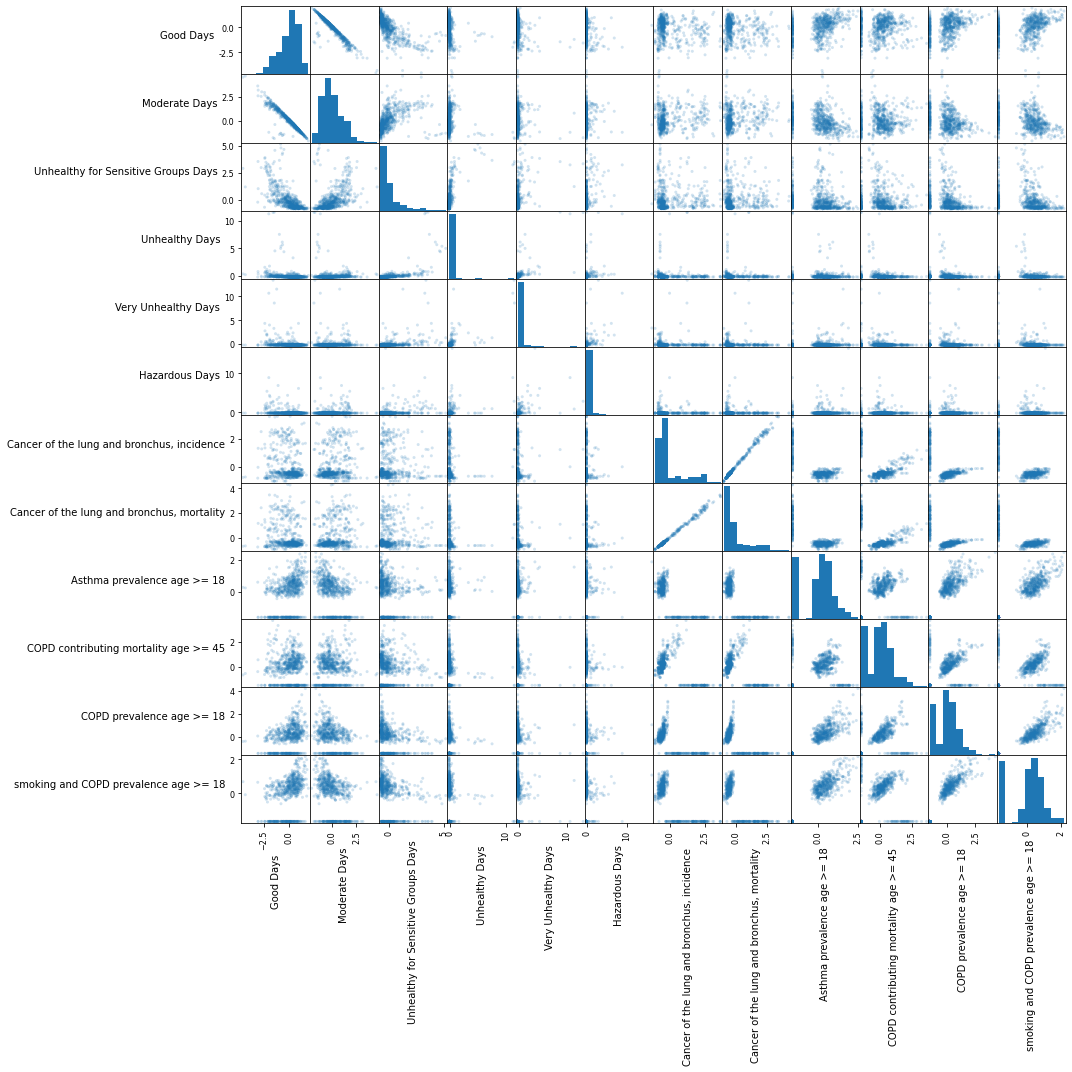

In [2059]:
# need a bare-bones dataframe else scatter matrix will be too crowded
scatter_df = merged_df[['Good Days', 'Moderate Days',
       'Unhealthy for Sensitive Groups Days', 'Unhealthy Days',
       'Very Unhealthy Days', 'Hazardous Days',
       'Cancer of the lung and bronchus, incidence',
       'Cancer of the lung and bronchus, mortality',
       'Asthma prevalence age >= 18', 'COPD contributing mortality age >= 45',
       'COPD prevalence age >= 18', 'smoking and COPD prevalence age >= 18']]

axes = pd.plotting.scatter_matrix(scatter_df, alpha=0.2, figsize=(15,15))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()


In [2062]:
merged_df.reset_index(drop=False)

,State,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,...,Chronic Obstructive Pulmonary Disease,"Cancer of the lung and bronchus, incidence","Cancer of the lung and bronchus, mortality",Asthma prevalence age >= 18,COPD mortality age >= 45,COPD contributing mortality age >= 45,COPD prevalence age >= 18,COPD prevalence age >= 45,smoking and COPD prevalence age >= 18,smoking and COPD prevalence age >= 45
0,Alabama,2008,-0.986944,-1.466906,1.720842,-0.042992,-0.164624,-0.203091,-0.204273,-0.082339,...,-2.180759,2.450761,2.598888,-1.616216,-1.436620,-1.437096,-1.465177,-1.477781,-1.648406,-1.630630
1,Alabama,2009,-0.927490,-0.326800,0.551916,-0.606457,-0.226271,-0.203091,-0.204273,-0.450583,...,-2.180759,2.398877,2.598888,-1.616216,-1.436620,-1.437096,-1.465177,-1.477781,-1.648406,-1.630630
2,Alabama,2010,-0.724525,-1.780720,2.068721,0.002410,-0.164000,-0.203091,-0.204273,-0.134718,...,-0.465701,0.574292,0.704708,-1.616216,2.527546,2.021710,-1.465177,-1.477781,-1.648406,-1.630630
3,Alabama,2011,-1.704497,-0.922197,1.073748,0.080874,-0.157717,-0.203091,-0.204273,-0.171225,...,0.105986,-0.428317,-0.334460,-0.151082,0.348723,0.119610,0.763916,0.588871,0.544787,0.624164
4,Alabama,2012,-1.445592,-0.145575,0.241227,-0.140674,-0.186103,-0.203091,-0.204273,-0.273264,...,0.105986,-0.430239,-0.344482,-0.041197,0.384578,0.102034,0.833575,0.778182,0.165014,0.074462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,Wyoming,2016,0.314780,0.880136,-0.788823,-0.779223,-0.218001,-0.203091,-0.204273,-0.623595,...,0.759341,-0.735778,-0.678970,0.620729,0.699857,0.829902,0.624597,0.591125,0.274198,-0.086231
659,Wyoming,2017,0.407037,-0.001480,0.141795,-0.522321,-0.151638,0.036438,0.063754,1.100451,...,0.759341,-0.735778,-0.678970,0.526542,0.943072,0.867833,0.535036,0.611408,0.420683,0.280237
660,Wyoming,2018,0.392465,-0.022259,0.195826,-0.586757,-0.202776,-0.203091,-0.204273,-0.366988,...,0.759341,-0.735778,-0.678970,0.432355,1.224438,1.177740,0.445474,0.570841,0.768583,0.790674
661,Wyoming,2019,0.797370,0.803116,-0.739755,-0.607200,-0.202776,-0.203091,-0.204273,-0.516455,...,0.759341,NaN,NaN,0.620729,1.022554,1.176125,0.564890,0.793958,0.823514,0.548543


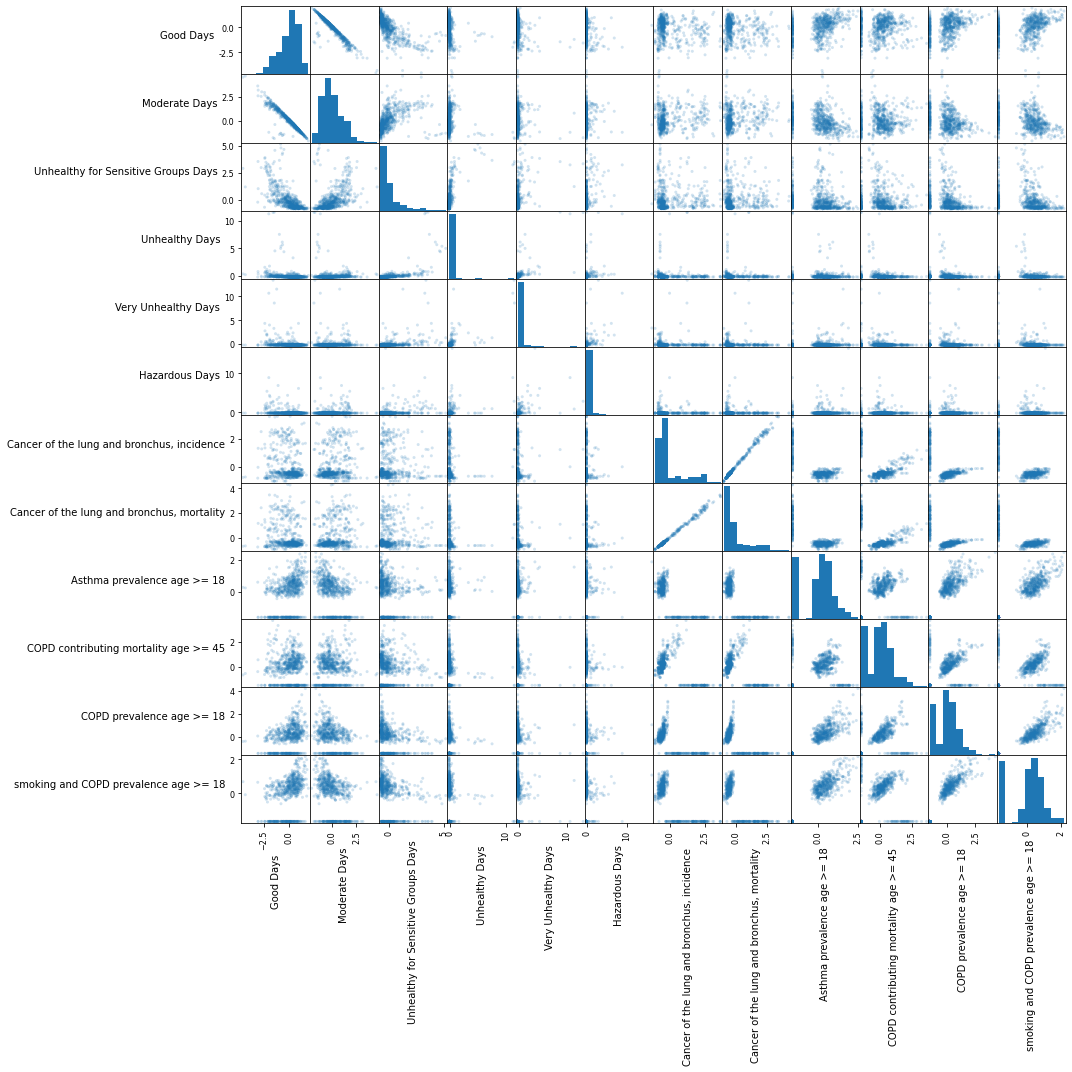

In [2063]:
# need a bare-bones dataframe else scatter matrix will be too crowded
scatter_df = merged_df[['Good Days', 'Moderate Days',
       'Unhealthy for Sensitive Groups Days', 'Unhealthy Days',
       'Very Unhealthy Days', 'Hazardous Days',
       'Cancer of the lung and bronchus, incidence',
       'Cancer of the lung and bronchus, mortality',
       'Asthma prevalence age >= 18', 'COPD contributing mortality age >= 45',
       'COPD prevalence age >= 18', 'smoking and COPD prevalence age >= 18']]

scatter_df = scatter_df.replace(0,np.nan)

axes = pd.plotting.scatter_matrix(scatter_df, alpha=0.2, figsize=(15,15))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

In [2061]:
scatter_df

Good Days  Moderate Days  Unhealthy for Sensitive Groups Days  \
State   Year                                                                  
Alabama 2008  -1.466906       1.720842                            -0.042992   
        2009  -0.326800       0.551916                            -0.606457   
        2010  -1.780720       2.068721                             0.002410   
        2011  -0.922197       1.073748                             0.080874   
        2012  -0.145575       0.241227                            -0.140674   
...                 ...            ...                                  ...   
Wyoming 2016   0.880136      -0.788823                            -0.779223   
        2017  -0.001480       0.141795                            -0.522321   
        2018  -0.022259       0.195826                            -0.586757   
        2019   0.803116      -0.739755                            -0.607200   
        2020   0.730367      -0.740223                            -0.326251   

              Unhealthy Days  Very Unhealthy Days  Hazardous Days  \
State   Year                                                        
Alabama 2008       -0.164624            -0.203091       -0.204273   
        2009       -0.226271            -0.203091       -0.204273   
        2010       -0.164000            -0.203091       -0.204273   
        2011       -0.157717            -0.203091       -0.204273   
        2012       -0.186103            -0.203091       -0.204273   
...                      ...                  ...             ...   
Wyoming 2016       -0.218001            -0.203091       -0.204273   
        2017       -0.151638             0.036438        0.063754   
        2018       -0.202776            -0.203091       -0.204273   
        2019       -0.202776            -0.203091       -0.204273   
        2020       -0.109114            -0.018781        0.048172   

              Cancer of the lung and bronchus, incidence  \
State   Year                                               
Alabama 2008                                    2.450761   
        2009                                    2.398877   
        2010                                    0.574292   
        2011                                   -0.428317   
        2012                                   -0.430239   
...                                                  ...   
Wyoming 2016                                   -0.735778   
        2017                                   -0.735778   
        2018                                   -0.735778   
        2019                                         NaN   
        2020                                         NaN   

              Cancer of the lung and bronchus, mortality  \
State   Year                                               
Alabama 2008                                    2.598888   
        2009                                    2.598888   
        2010                                    0.704708   
        2011                                   -0.334460   
        2012                                   -0.344482   
...                                                  ...   
Wyoming 2016                                   -0.678970   
        2017                                   -0.678970   
        2018                                   -0.678970   
        2019                                         NaN   
        2020                                         NaN   

              Asthma prevalence age >= 18  \
State   Year                                
Alabama 2008                    -1.616216   
        2009                    -1.616216   
        2010                    -1.616216   
        2011                    -0.151082   
        2012                    -0.041197   
...                                   ...   
Wyoming 2016                     0.620729   
        2017                     0.526542   
        2018                     0.432355   
        2019                   

In [93]:
#COPD contributing mortality age >= 45
pd.melt(merged_df.reset_index(drop=False),
        id_vars=['State','Year'], 
        var_name='Measures', 
        value_vars=['COPD contributing mortality age >= 45'],
        value_name='Target')

,State,Year,Measures,Target
0,Alabama,2008,COPD contributing mortality age >= 45,0.000000
1,Alabama,2009,COPD contributing mortality age >= 45,0.000000
2,Alabama,2010,COPD contributing mortality age >= 45,0.250000
3,Alabama,2011,COPD contributing mortality age >= 45,0.111111
4,Alabama,2012,COPD contributing mortality age >= 45,0.111111
...,...,...,...,...
658,Wyoming,2016,COPD contributing mortality age >= 45,0.142857
659,Wyoming,2017,COPD contributing mortality age >= 45,0.142857
660,Wyoming,2018,COPD contributing mortality age >= 45,0.142857
661,Wyoming,2019,COPD contributing mortality age >= 45,0.142857


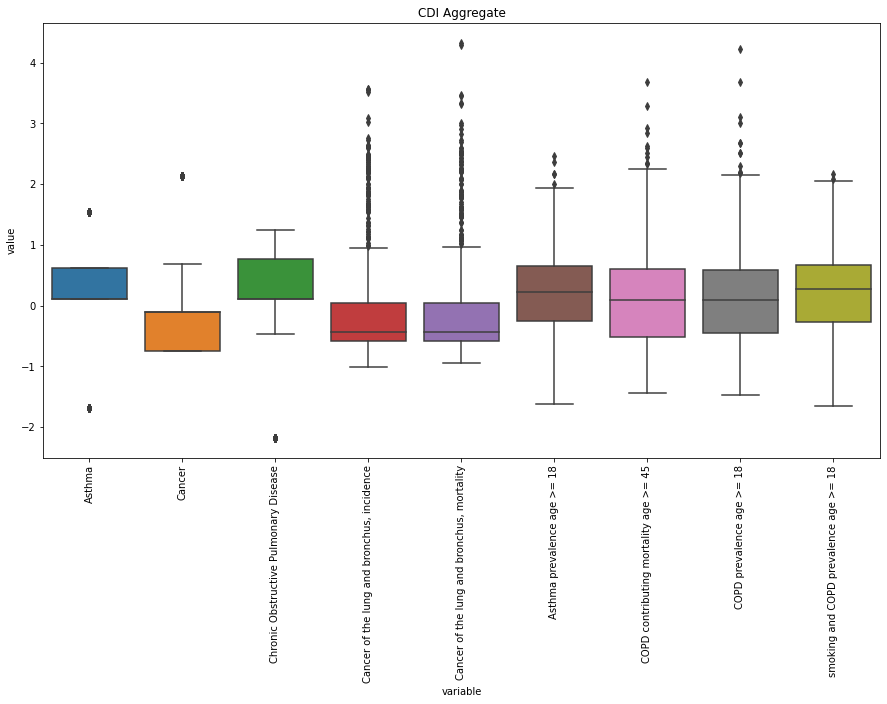

In [2100]:
temp = merged_df[['Asthma', 'Cancer',
                'Chronic Obstructive Pulmonary Disease',
                'Cancer of the lung and bronchus, incidence',
                'Cancer of the lung and bronchus, mortality',
                'Asthma prevalence age >= 18',
                'COPD contributing mortality age >= 45',
                'COPD prevalence age >= 18',
                'smoking and COPD prevalence age >= 18']]

plt.subplots(figsize=(15, 8))
sns.boxplot(x="variable", y="value", data=pd.melt(temp)).set_title('CDI Aggregate')
plt.xticks(rotation='vertical');

Let's look at how AQI values correlate to Cancer.

In [2096]:
corr_matrix = merged_df.corr()
corr_matrix['Cancer'].sort_values(ascending=False)

Cancer                                        1.000000
Cancer of the lung and bronchus, incidence    0.898992
Cancer of the lung and bronchus, mortality    0.894037
Moderate Days                                 0.310916
90th Percentile AQI                           0.290283
Unhealthy for Sensitive Groups Days           0.187953
Median AQI                                    0.186369
Days CO                                       0.162684
Days NO2                                      0.142422
Days PM10                                     0.093599
Max AQI                                       0.091682
Days SO2                                      0.077952
Unhealthy Days                                0.069528
Very Unhealthy Days                           0.056521
Days PM2.5                                    0.016576
Hazardous Days                               -0.030373
Days Ozone                                   -0.112046
Days with AQI                                -0.220201
Good Days 

__Positive Correlations__

|Feature | Pearson's r |
|--------|-------------|
| Moderate Days                                 |0.310916
| 90th Percentile AQI                           |0.290283
| Unhealthy for Sensitive Groups Days           |0.187953
| Median AQI                                    |0.186369
| Days CO                                       |0.162684
| Days NO2                                      |0.142422
| Days PM10                                     |0.093599
| Max AQI                                       |0.091682
| Days SO2                                      |0.077952
| Unhealthy Days                                |0.069528
| Very Unhealthy Days                           |0.056521
| Days PM2.5                                    |0.016576

__Negative Correlations__

|Feature | Pearson's r |
|--------|-------------|
|Hazardous Days                               |-0.030373
|Days Ozone                                   |-0.112046
|Days with AQI                                |-0.220201
|Good Days                                    |-0.321237

Now let's look at AQI correlations to Asthma

In [2097]:
corr_matrix = merged_df.corr()
corr_matrix['Asthma'].sort_values(ascending=False)

Asthma                                        1.000000
Asthma prevalence age >= 18                   0.968830
smoking and COPD prevalence age >= 45         0.953240
smoking and COPD prevalence age >= 18         0.950956
COPD prevalence age >= 45                     0.886745
Chronic Obstructive Pulmonary Disease         0.875173
COPD prevalence age >= 18                     0.870895
Good Days                                     0.376990
Days with AQI                                 0.206235
Days Ozone                                    0.095284
COPD contributing mortality age >= 45         0.092780
COPD mortality age >= 45                      0.084434
Hazardous Days                                0.048632
Days PM2.5                                   -0.009769
Very Unhealthy Days                          -0.028968
Days SO2                                     -0.060835
Unhealthy Days                               -0.072600
Days PM10                                    -0.082998
Max AQI   

__Positive Correlations__

|Feature | Pearson's r |
|--------|-------------|
|Good Days                                     |0.376990
|Days with AQI                                 |0.206235
|Days Ozone                                    |0.095284
|Hazardous Days                                |0.048632

__Negative Correlations__

|Feature | Pearson's r |
|--------|-------------|
|Days PM2.5                                   |-0.009769
|Very Unhealthy Days                          |-0.028968
|Days SO2                                     |-0.060835
|Unhealthy Days                               |-0.072600
|Days PM10                                    |-0.082998
|Max AQI                                      |-0.097049
|Days NO2                                     |-0.144309
|Days CO                                      |-0.160451
|Unhealthy for Sensitive Groups Days          |-0.220673
|Median AQI                                   |-0.228461
|90th Percentile AQI                          |-0.349134
|Moderate Days                                |-0.367569

Finally, here are the AQI correlations to COPD

In [2098]:
corr_matrix = merged_df.corr()
corr_matrix['Chronic Obstructive Pulmonary Disease'].sort_values(ascending=False)

Chronic Obstructive Pulmonary Disease         1.000000
Asthma                                        0.875173
Asthma prevalence age >= 18                   0.844386
smoking and COPD prevalence age >= 18         0.842203
smoking and COPD prevalence age >= 45         0.841289
COPD prevalence age >= 45                     0.777960
COPD prevalence age >= 18                     0.767395
COPD contributing mortality age >= 45         0.513638
COPD mortality age >= 45                      0.508080
Good Days                                     0.302344
Days with AQI                                 0.218310
Days Ozone                                    0.113130
Hazardous Days                                0.025834
Days PM2.5                                   -0.017654
Very Unhealthy Days                          -0.061115
Unhealthy Days                               -0.067346
Days SO2                                     -0.079863
Max AQI                                      -0.088525
Days PM10 

__Positive Correlations__

|Feature | Pearson's r |
|--------|-------------|
|Good Days                                     |0.302344
|Days with AQI                                 |0.218310
|Days Ozone                                    |0.113130
|Hazardous Days                                |0.025834

__Negative Correlations__

|Feature | Pearson's r |
|--------|-------------|
|Days PM2.5                                   |-0.017654
|Very Unhealthy Days                          |-0.061115
|Unhealthy Days                               |-0.067346
|Days SO2                                     |-0.079863
|Max AQI                                      |-0.088525
|Days PM10                                    |-0.093784
|Days NO2                                     |-0.138885
|Days CO                                      |-0.159574
|Median AQI                                   |-0.173342
|Unhealthy for Sensitive Groups Days          |-0.176878
|90th Percentile AQI                          |-0.271416
|Moderate Days                                |-0.292060

### Feature Engineering

### TODO: 
- look up source data type (%, proportion, etc)
- may need to correct for this???
- good and moderate days look like mirror images
- COPD data is horribly distributed

## Backlog

In [ ]:
cali = aqi_df[aqi_df['State'] == 'California']

In [ ]:
# melt to give us County vs Median AQI, Days Ozone
temp = pd.melt(cali[['County', 'Median AQI', 'Days Ozone']],
                        id_vars='County', 
                        var_name='Measures', 
                        value_vars=['Median AQI', 'Days Ozone'],
                        value_name='Target')

plt.subplots(figsize=(15, 8))
sns.boxplot(x='County', y='Target', hue='Measures', data=temp.sort_values('County'))
plt.xticks(rotation='vertical')
plt.ylabel('Values')
plt.xlabel('County')
plt.title('Median AQI vs Ozone')
plt.legend(loc='upper right');

Median AQI nearly always lags behind the median Ozone value. Beyond that, its difficult to see any linear relationship here (perhaps because of CO measure variance). Still, this merits further exploration in the EDA stage.

In [ ]:
# melt to give us County vs Median AQI, Days CO
temp = pd.melt(cali[['County', 'Median AQI', 'Days CO']],
                        id_vars='County', 
                        var_name='Measures', 
                        value_vars=['Median AQI', 'Days CO'],
                        value_name='Target')

plt.subplots(figsize=(15, 8))
sns.boxplot(x='County', y='Target', hue='Measures', data=temp.sort_values('County'))
plt.xticks(rotation='vertical')
plt.ylabel('Values')
plt.xlabel('County')
plt.title('Median AQI vs CO')
plt.legend(loc='upper right');

The median AQI always exceeds the median of the CO values. There does _seem_ to be a linear relationship here.

In [ ]:
# melt to give us County vs Median AQI, Days NO2
temp = pd.melt(cali[['County', 'Median AQI', 'Days NO2']],
                        id_vars='County', 
                        var_name='Measures', 
                        value_vars=['Median AQI', 'Days NO2'],
                        value_name='Target')

plt.subplots(figsize=(15, 8))
sns.boxplot(x='County', y='Target', hue='Measures', data=temp.sort_values('County'))
plt.xticks(rotation='vertical')
plt.ylabel('Values')
plt.xlabel('County')
plt.title('Median AQI vs NO2')
plt.legend(loc='upper right');

NO2 values have high variance, but seem to either be below the median AQI or equal to it (for the most part). Correlations should be explored in EDA phase.

In [ ]:
# melt to give us County vs Median AQI, Days SO2
temp = pd.melt(cali[['County', 'Median AQI', 'Days SO2']],
                        id_vars='County', 
                        var_name='Measures', 
                        value_vars=['Median AQI', 'Days SO2'],
                        value_name='Target')

plt.subplots(figsize=(15, 8))
sns.boxplot(x='County', y='Target', hue='Measures', data=temp.sort_values('County'))
plt.xticks(rotation='vertical')
plt.ylabel('Values')
plt.xlabel('County')
plt.title('Median AQI vs SO2')
plt.legend(loc='upper right');

The median for Days SO2 always stays below the median AQI. Not a lot of variance in SO2 values, but that is likely because there are so few days of measurable SO2. I doubt that this feature will be predictive of AQI.

Lets take a look at the mean of all the values above against the AQI

In [ ]:
temp = cali[['County', 'Median AQI']].copy()
mean_measures = cali.loc[:,['Days CO', 'Days NO2', 'Days Ozone', 'Days SO2']].mean(axis=1)
temp.loc[:, 'Means'] = mean_measures

temp = pd.melt(temp[['County', 'Median AQI', 'Means']],
                        id_vars='County', 
                        var_name='Measures', 
                        value_vars=['Median AQI', 'Means'],
                        value_name='Target')

plt.subplots(figsize=(15, 8))
sns.boxplot(x='County', y='Target', hue='Measures', data=temp.sort_values('County'))
plt.xticks(rotation='vertical')
plt.ylabel('Average Values')
plt.xlabel('County')
plt.title('Median AQI vs Average Measures')
plt.legend(loc='upper right');

In [ ]:
# melt to give us County vs Median AQI, Days SO2
temp = pd.melt(cali[['County', 'Median AQI', 'Days SO2']],
                        id_vars='County', 
                        var_name='Measures', 
                        value_vars=['Median AQI', 'Days SO2'],
                        value_name='Target')

plt.subplots(figsize=(15, 8))
sns.boxplot(x='County', y='Target', hue='Measures', data=temp.sort_values('County'))
plt.xticks(rotation='vertical')
plt.ylabel('Values')
plt.xlabel('County')
plt.title('Median AQI vs SO2')
plt.legend(loc='upper right');

In [2235]:
l = np.array([-0.082339,0.875468,1.027625,0.173517,-0.696134,-0.066775,-0.635281,0.461936,-0.290967])
l.sum()

0.76705